# 位宽分配算法测试

In [60]:
from allocate import *

fisher_info = load_json('/root/autodl-tmp/data.json')

bits = [2,4,8]
target_bits = 4.3
layers_num = len(fisher_info)*len(fisher_info[0])

allocation_strategy = Greedy_allocation_list(bits, target_bits, layers_num)
res = get_bits_list(fisher_info,allocation_strategy)

print(res)

None


In [51]:
def sort_FI_layer(data):
    from collections import defaultdict
    values_dict = defaultdict(list)
    for block in data:
        for key, value in block.items():
            values_dict[key].append(value)

    rank_dict = {}
    for key, values in values_dict.items():
        sorted_values = sorted(values, reverse=True)
        ranks = {v: i + 1 for i, v in enumerate(sorted_values)}
        rank_dict[key] = [ranks[v] for v in values]
    return rank_dict

def sort_FI_in_all(data):
    from collections import defaultdict

    all_values = []
    for index, block in enumerate(data):
        for key, value in block.items():
            all_values.append((f"{index}_{key}", value)) 

    sorted_values = sorted(all_values, key=lambda x: x[1], reverse=False)
    rank_dict = {}
    for rank, (combined_key, _) in enumerate(sorted_values, start=1):
        index, key = combined_key.split('_', 1)  
        rank_dict[(int(index), key)] = rank  

    result = defaultdict(dict)
    for (index, key), rank in rank_dict.items():
        result[index][key] = rank

    return dict(result)

In [57]:
# 判断当前排序的位宽结果
def judge_bits(rank,allocation_strategy):
    total_nums = 0
    for bit,nums in allocation_strategy.items():
        total_nums += nums
        if rank < total_nums or rank == total_nums:
            return bit

def get_bits_list(fisher_info, strategy):
    sorted_FI = sort_FI_in_all(fisher_info)
    res = []
    for index,layer_FI_rank in sorted_FI.items():
        layers_bit = {}
        for layer_name,FI_rank in layer_FI_rank.items():
            bit = judge_bits(FI_rank,strategy)
            layers_bit[layer_name] = bit
        res.append(layers_bit)
    return res

res = get_bits_list(fisher_info, allocation_strategy)
print(res)

[{'self_attn.q_proj.weight': 2, 'mlp.gate_proj.weight': 2, 'mlp.down_proj.weight': 2, 'mlp.up_proj.weight': 2, 'self_attn.k_proj.weight': 2, 'self_attn.o_proj.weight': 2, 'self_attn.v_proj.weight': 2}, {'self_attn.q_proj.weight': 2, 'self_attn.k_proj.weight': 2, 'mlp.down_proj.weight': 2, 'mlp.up_proj.weight': 2, 'mlp.gate_proj.weight': 2, 'self_attn.v_proj.weight': 2, 'self_attn.o_proj.weight': 2}, {'mlp.down_proj.weight': 2, 'self_attn.q_proj.weight': 2, 'mlp.up_proj.weight': 2, 'mlp.gate_proj.weight': 2, 'self_attn.k_proj.weight': 2, 'self_attn.v_proj.weight': 2, 'self_attn.o_proj.weight': 2}, {'mlp.down_proj.weight': 2, 'mlp.up_proj.weight': 2, 'mlp.gate_proj.weight': 2, 'self_attn.q_proj.weight': 2, 'self_attn.k_proj.weight': 2, 'self_attn.v_proj.weight': 2, 'self_attn.o_proj.weight': 2}, {'mlp.down_proj.weight': 2, 'mlp.up_proj.weight': 2, 'mlp.gate_proj.weight': 2, 'self_attn.k_proj.weight': 2, 'self_attn.q_proj.weight': 2, 'self_attn.o_proj.weight': 2, 'self_attn.v_proj.weight'

# 目标优化的搜索求解
$\min_{\{bit_i\}}\sum_{i=1}^{N}F_i\cdot e^{-\alpha (B/bit_i)} \quad \text{subject to } \sum_{i=1}^{N}p_i\cdot \frac{bit_i}{B} \le P_{comp}$

## 使用启发式算法进行求解（遗传算法）
* 优化：
  * 限制条件（淘汰不符合压缩结果——>逼近压缩率）
  * 子代生成 随机配种 ——> 大子群选优

## 随机交叉 非严格约束

In [46]:
'''
初始化参数
'''
import numpy as np
import random
import json

def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

# 参数设置
bits = [2, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 2  # 目标函数中的参数
population_size = 1000  # 种群大小
max_generations = 10000  # 最大迭代次数
mutation_rate = 0.2  # 变异概率

In [47]:
# 适应度函数
def fitness(individual):
    individual = np.array(individual)
    # 计算目标函数值
    objective = np.sum(F * np.exp(-alpha * (B / individual)))
    # 计算压缩率
    compression = np.sum(p * (individual / B)) / P_total
    # 惩罚项：如果压缩率不满足约束，适应度为0
    if compression > R or compression < R:
        return 0
    # 适应度为目标函数的倒数（越小越好）
    return 1 / (objective + 1e-9)

# 初始化种群
def initialize_population():
    population = []
    for _ in range(population_size):
        individual = [random.choice(bits) for _ in range(N)]
        population.append(individual)
    return population

def selection(population, fitness_values):
    selected = []
    for _ in range(population_size):
        candidates = random.sample(range(population_size), 2)
        winner = candidates[0] if fitness_values[candidates[0]] > fitness_values[candidates[1]] else candidates[1]
        selected.append(population[winner])
    return selected

def crossover(parent1, parent2):
    point = random.randint(1, N - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    # 修复子代个体，确保位宽值在 bits 中
    child1 = [min(bits, key=lambda x: abs(x - bit)) for bit in child1]
    child2 = [min(bits, key=lambda x: abs(x - bit)) for bit in child2]
    return child1, child2

def mutate(individual):
    for i in range(N):
        if random.random() < mutation_rate:
            individual[i] = random.choice(bits)
    return individual

def genetic_algorithm():
    
    population = initialize_population()
    best_fitness = 0
    best_individual = None

    for generation in range(max_generations):
        # 计算适应度
        fitness_values = [fitness(individual) for individual in population]
        # 更新最优解
        current_best_fitness = max(fitness_values)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[np.argmax(fitness_values)]
       
        selected = selection(population, fitness_values)
        
        new_population = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected[i], selected[i + 1]
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([child1, child2])
       
        new_population = [mutate(individual) for individual in new_population]
        population = new_population
        if (generation+1)%100 == 0:
            print(f"Generation {generation + 1}: Best Fitness = {best_fitness} ,Compression = {np.sum(p * (best_individual / B)) / P_total}")

    return best_individual, best_fitness

In [48]:
def count_occurrences(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique_elements, counts))
    
best_individual, best_fitness = genetic_algorithm()
print(count_occurrences(best_individual))
print("Best Individual (Bit Widths):", best_individual)
print("Best Fitness:", best_fitness)

Generation 1000: Best Fitness = 0.07342693652421041
Generation 2000: Best Fitness = 0.07342693652421041
Generation 3000: Best Fitness = 0.07342693652421041
Generation 4000: Best Fitness = 0.07629338009261975
Generation 5000: Best Fitness = 0.08141244840657157
Generation 6000: Best Fitness = 0.08141244840657157
Generation 7000: Best Fitness = 0.08141244840657157
Generation 8000: Best Fitness = 0.08141244840657157
Generation 9000: Best Fitness = 0.08141244840657157
Generation 10000: Best Fitness = 0.08141244840657157
{2: 100, 4: 80, 8: 44}
Best Individual (Bit Widths): [2, 2, 2, 4, 4, 2, 4, 2, 2, 2, 8, 2, 2, 4, 4, 2, 4, 2, 4, 4, 2, 4, 8, 2, 8, 2, 4, 4, 2, 2, 2, 2, 4, 2, 2, 4, 2, 4, 4, 8, 2, 2, 2, 2, 2, 2, 4, 4, 8, 2, 4, 4, 8, 2, 2, 4, 2, 8, 4, 2, 4, 2, 8, 4, 8, 8, 8, 4, 2, 2, 2, 8, 4, 2, 4, 4, 4, 8, 4, 2, 4, 8, 4, 4, 2, 2, 4, 4, 4, 2, 2, 8, 8, 8, 2, 8, 4, 8, 8, 2, 2, 4, 4, 2, 8, 8, 2, 8, 4, 4, 2, 4, 2, 2, 4, 2, 8, 4, 4, 4, 4, 8, 2, 2, 8, 2, 2, 4, 4, 4, 4, 8, 2, 4, 8, 2, 4, 4, 4, 4, 8, 2,

## 锦标赛（严格约束设置条件）

* 采用锦标赛方式(10进1)筛选子代。种群规模为10000
* 修改适应函数：
    * $\min_{\{bit_i\}}\sum_{i=1}^{N}F_i\cdot e^{-\alpha (B/bit_i)} + penalty$
    * $penalty = \beta * (R_{Actual} - R)^2$
* 随机变异：10%随机修改单层的位宽大小
* 引入个体修复机制：严格个体压缩率等于R。当个体的压缩率接近目标R时触发，$P_{total}​⋅R - \epsilon ≤ \sum_{i=1}^{N}​p_i​⋅B/bit_i​​ ≤ P_{total}​⋅R + \epsilon$
    * 压缩率高于目标值：找到当前个体中非最低位宽层中Fisher值最低的那一层，将该层的位宽调整到下一个更低位宽。
    * 压缩率低于目标值：找到当前个体中非最高位宽层中Fisher值最高的那一层。将该层的位宽调整到下一个更高位宽。

In [2]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import json


'''
初始化参数
'''
def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

# 参数设置
bits = [2, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 3  # 目标函数中的参数
population_size = 1000  # 种群大小
max_generations = 10000  # 最大迭代次数
mutation_rate = 0.2  # 变异概率


# 定义适应度函数和个体
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # 最小化问题
creator.create("Individual", list, fitness=creator.FitnessMin)

# 初始化工具箱
toolbox = base.Toolbox()
toolbox.register("attr_bit", random.choice, bits)  # 每个基因从 bits 中选择
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bit, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 定义适应度函数
def evaluate(individual):
    # 计算目标函数值
    objective = sum(F[i] * np.exp(-alpha * (B / individual[i])) for i in range(N))
    
    # 计算约束条件
    constraint = sum(p[i] * (individual[i] / B) for i in range(N)) - P_total * R
    
    # 添加惩罚项（约束不满足时适应度变差）
    penalty = 1000 * abs(constraint)  # 惩罚系数
    return objective + penalty,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # 两点交叉

# 自定义变异函数
def custom_mutate(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:  # 以 indpb 的概率进行变异
            # 从 bits 中随机选择一个不同于当前值的位宽
            new_bit = random.choice([bit for bit in bits if bit != individual[i]])
            individual[i] = new_bit
    return individual,

toolbox.register("mutate", custom_mutate, indpb=0.1)  # 自定义变异
toolbox.register("select", tools.selTournament, tournsize=10)  # 竞标赛选择，规模为 10

# 初始化种群
population = toolbox.population(n=10000)

# 精英保留策略
def eaWithElitism(population, toolbox, cxpb, mutpb, ngen, elite_size=10, verbose=True):
    logbook = tools.Logbook()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    
    # 初始种群评估
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    for gen in range(ngen):
        # 选择下一代
        offspring = toolbox.select(population, len(population) - elite_size)
        offspring = list(map(toolbox.clone, offspring))
        
        # 交叉和变异
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # 评估新个体
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # 保留精英
        elite = tools.selBest(population, elite_size)
        offspring.extend(elite)
        
        # 更新种群
        population[:] = offspring
        
        # 记录统计信息
        logbook.record(gen=gen, **stats.compile(population))
        if verbose:
            print(logbook.stream)
    
    return population, logbook

# 运行遗传算法
result, log = eaWithElitism(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, elite_size=20, verbose=True
)

# 输出最优解
best_individual = tools.selBest(result, k=1)[0]
best_fitness = best_individual.fitness.values[0]
print("Best individual:", best_individual)
print("Best fitness:", best_fitness)

/root/miniconda3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/root/miniconda3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	min        
0  	1.31072e+08
1  	2.30833    
2  	1.96618    
3  	1.93792    
4  	1.89286    
5  	1.87744    
6  	1.87744    
7  	1.87744    
8  	1.87744    
9  	1.83258    
10 	1.7319     
11 	1.71261    
12 	1.71261    
13 	1.69996    
14 	1.69996    
15 	1.65721    
16 	1.62527    
17 	1.62527    
18 	1.61868    
19 	1.58673    
20 	1.57815    
21 	1.57815    
22 	1.5482     
23 	1.54515    
24 	1.50512    
25 	1.50186    
26 	1.50186    
27 	1.44032    
28 	1.44032    
29 	1.44032    
30 	1.44032    
31 	1.44032    
32 	1.42264    
33 	1.42264    
34 	1.4013     
35 	1.4013     
36 	1.40128    
37 	1.40127    
38 	1.40127    
39 	1.40127    
40 	1.40127    
41 	1.40127    
42 	1.3931     
43 	1.3931     
44 	1.3863     
45 	1.33577    
46 	1.33577    
47 	1.33117    
48 	1.33117    
49 	1.33117    
50 	1.29767    
51 	1.29767    
52 	1.29767    
53 	1.29533    
54 	1.29533    
55 	1.29274    
56 	1.2766     
57 	1.2766     
58 	1.2766     
59 	1.27006    
60 	1.23558    
61 	1.23

## 锦标赛（引入宽松限制与修复函数）

In [18]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import json

def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)


# 修复函数：基于敏感度的定向修复
def repair_individual(individual):
    """
    基于敏感度的定向修复，使个体严格满足约束条件。
    位宽调整严格限制在 bits = [2, 4, 8] 中。
    如果无法修复，则返回原始个体并标记为不可修复。
    """
    def get_current_sum(ind):
        return sum(p[i] * (ind[i] / B) for i in range(N))
    
    target_sum = P_total * R
    current_sum = get_current_sum(individual)
    max_attempts = 3  # 最大修复尝试次数
    attempt = 0
    
    while abs(current_sum - target_sum) > 1e-6 and attempt < max_attempts:
        if current_sum > target_sum:
            # 压缩率高于目标值：降低某层的位宽
            # 找到非最低位宽层中 Fisher 值最低的层
            candidate_indices = [i for i in range(N) if individual[i] > min(bits)]
            if not candidate_indices:
                break  # 没有可调整的层
            target_idx = min(candidate_indices, key=lambda i: F[i])
            # 将该层的位宽调整到下一个更低位宽
            current_bit = individual[target_idx]
            current_bit_index = bits.index(current_bit)
            new_bit = bits[current_bit_index - 1] if current_bit_index > 0 else current_bit
        else:
            # 压缩率低于目标值：提高某层的位宽
            # 找到非最高位宽层中 Fisher 值最高的层
            candidate_indices = [i for i in range(N) if individual[i] < max(bits)]
            if not candidate_indices:
                break  # 没有可调整的层
            target_idx = max(candidate_indices, key=lambda i: F[i])
            # 将该层的位宽调整到下一个更高位宽
            current_bit = individual[target_idx]
            current_bit_index = bits.index(current_bit)
            new_bit = bits[current_bit_index + 1] if current_bit_index < len(bits) - 1 else current_bit
        
        # 更新位宽
        individual[target_idx] = new_bit
        current_sum = get_current_sum(individual)
        attempt += 1
    
    # 检查是否修复成功
    if abs(current_sum - target_sum) <= 1e-6:
        return individual, True  # 修复成功
    else:
        return individual, False  # 修复失败

# 适应度函数
def evaluate(individual):
    # 尝试修复个体
    repaired_individual, is_repaired = repair_individual(individual)
    
    if is_repaired:
        # 如果修复成功，则计算目标函数值
        objective = sum(F[i] * np.exp(-alpha * (B / repaired_individual[i])) for i in range(N))
        return objective,
    else:
        # 如果修复失败，则添加高代价惩罚项
        constraint = sum(p[i] * (individual[i] / B) for i in range(N)) - P_total * R
        penalty = 1e6 * (constraint ** 2)  # 高代价惩罚项
        return 1e6 + penalty,  # 返回一个较大的值表示不可行解

# 自定义变异函数
def custom_mutate(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:  # 以 indpb 的概率进行变异
            # 从 bits 中随机选择一个不同于当前值的位宽
            new_bit = random.choice([bit for bit in bits if bit != individual[i]])
            individual[i] = new_bit
    return individual,

# 精英保留策略
def eaWithElitism(population, toolbox, cxpb, mutpb, ngen, elite_size=10, verbose=True):
    logbook = tools.Logbook()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    
    # 初始种群评估
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    for gen in range(ngen):
        # 选择下一代
        offspring = toolbox.select(population, len(population) - elite_size)
        offspring = list(map(toolbox.clone, offspring))
        
        # 交叉和变异
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # 评估新个体
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # 保留精英
        elite = tools.selBest(population, elite_size)
        offspring.extend(elite)
        
        # 更新种群
        population[:] = offspring
        
        # 记录统计信息
        logbook.record(gen=gen, **stats.compile(population))
        if verbose:
            print(logbook.stream)
    
    return population, logbook

In [9]:
# 参数设置
bits = [2, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 3  # 目标函数中的参数
population_size = 1000  # 种群大小
max_generations = 10000  # 最大迭代次数
epsilon = 1e-2  # 容差值

# 定义适应度函数和个体
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # 最小化问题
creator.create("Individual", list, fitness=creator.FitnessMin)

# 初始化工具箱
toolbox = base.Toolbox()
toolbox.register("attr_bit", random.choice, bits)  # 每个基因从 bits 中选择
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bit, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # 两点交叉
toolbox.register("mutate", custom_mutate, indpb=0.1)  # 自定义变异
# toolbox.register("mutate", tools.mutUniformInt, low=min(bits), up=max(bits), indpb=0.1)  # 均匀变异
toolbox.register("select", tools.selTournament, tournsize=10)  # 竞标赛选择，规模为 10
# 初始化种群
population = toolbox.population(n=10000)

# 运行遗传算法
result, log = eaWithElitism(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=500, elite_size=20, verbose=True
)

# 输出最优解
best_individual = tools.selBest(result, k=1)[0]
best_fitness = best_individual.fitness.values[0]
print("Best individual:", best_individual)
print("Best fitness:", best_fitness)

gen	min    
0  	4.14647
1  	1.77777
2  	1.77777
3  	1.77777
4  	1.77777
5  	1.74337
6  	1.73466
7  	1.68324
8  	1.67239
9  	1.62966
10 	1.62536
11 	1.58653
12 	1.57932
13 	1.54609
14 	1.52261
15 	1.51081
16 	1.48645
17 	1.48336
18 	1.4516 
19 	1.4516 
20 	1.44754
21 	1.41135
22 	1.4065 
23 	1.4065 
24 	1.38901
25 	1.35887
26 	1.32255
27 	1.32255
28 	1.32255
29 	1.32255
30 	1.30978
31 	1.30842
32 	1.30842
33 	1.28312
34 	1.27331
35 	1.2681 
36 	1.268  
37 	1.26328
38 	1.26265
39 	1.2491 
40 	1.23317
41 	1.23306
42 	1.23306
43 	1.21329
44 	1.18003
45 	1.1775 
46 	1.14862
47 	1.14168
48 	1.14157
49 	1.14157
50 	1.12518
51 	1.12518
52 	1.12518
53 	1.12508
54 	1.10062
55 	1.10052
56 	1.10052
57 	1.10052
58 	1.10052
59 	1.10052
60 	1.10052
61 	1.08042
62 	1.08042
63 	1.08042
64 	1.08042
65 	1.04987
66 	1.04987
67 	1.04986
68 	1.04986
69 	1.04842
70 	1.04842
71 	1.04842
72 	1.04841
73 	1.04841
74 	1.04841
75 	1.04841
76 	1.04841
77 	1.04841
78 	1.04841
79 	1.04841
80 	1.04841
81 	1.04841
82 	

In [19]:
# 参数设置
bits = [2, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 3  # 目标函数中的参数
population_size = 1000  # 种群大小
max_generations = 10000  # 最大迭代次数
epsilon = 1e-2  # 容差值

# 定义适应度函数和个体
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # 最小化问题
creator.create("Individual", list, fitness=creator.FitnessMin)

# 初始化工具箱
toolbox = base.Toolbox()
toolbox.register("attr_bit", random.choice, bits)  # 每个基因从 bits 中选择
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bit, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # 两点交叉
toolbox.register("mutate", custom_mutate, indpb=0.1)  # 自定义变异
# toolbox.register("mutate", tools.mutUniformInt, low=min(bits), up=max(bits), indpb=0.1)  # 均匀变异
toolbox.register("select", tools.selTournament, tournsize=10)  # 竞标赛选择，规模为 10
# 初始化种群
population = toolbox.population(n=10000)

# 运行遗传算法
result, log = eaWithElitism(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=500, elite_size=20, verbose=True
)

# 输出最优解
best_individual = tools.selBest(result, k=1)[0]
best_fitness = best_individual.fitness.values[0]
print("Best individual:", best_individual)
print("Best fitness:", best_fitness)
c = sum(p[i] * (best_individual[i] / B) for i in range(N))/P_total
print("Best individual compression:", c)

gen	min    
0  	2.32875
1  	1.91612
2  	1.90227
3  	1.90227
4  	1.90227
5  	1.8678 
6  	1.76707
7  	1.76707
8  	1.76707
9  	1.70196
10 	1.68965
11 	1.68794
12 	1.67013
13 	1.58081
14 	1.58081
15 	1.58081
16 	1.49087
17 	1.49087
18 	1.49087
19 	1.49087
20 	1.47075
21 	1.44272
22 	1.4403 
23 	1.41651
24 	1.40381
25 	1.38105
26 	1.35881
27 	1.30497
28 	1.30497
29 	1.27613
30 	1.25404
31 	1.25404
32 	1.2171 
33 	1.2171 
34 	1.2171 
35 	1.19839
36 	1.1907 
37 	1.16227
38 	1.15952
39 	1.13315
40 	1.11465
41 	1.11409
42 	1.08141
43 	1.07702
44 	1.07544
45 	1.07531
46 	1.04843
47 	1.04456
48 	1.04456
49 	1.04235
50 	1.03862
51 	1.03862
52 	1.01153
53 	1.01153
54 	1.01152
55 	1.01152
56 	1.01152
57 	1.01152
58 	1.01152
59 	1.01152
60 	1.01152
61 	1.01152
62 	1.01152
63 	1.01152
64 	1.01152
65 	1.00209
66 	1.00209
67 	1.00209
68 	1.00209
69 	1.00209
70 	1.00209
71 	0.96353
72 	0.96353
73 	0.96353
74 	0.96353
75 	0.957264
76 	0.957264
77 	0.956984
78 	0.893057
79 	0.893057
80 	0.893057
81 	0.8913

## 使用动态规划算法进行求解（存在问题:最有子问题条件无法满足）

In [18]:
import numpy as np
from collections import defaultdict
import math
from functools import reduce

def gcd_two_numbers(a, b):
    while b:
        a, b = b, a % b
    return a

def gcd_of_array(arr):
    if arr.size == 0:
        return None  # 如果数组为空，返回 None
    return reduce(gcd_two_numbers, arr.tolist())

def bitwidth_allocation_dp(N, bits, F, p, B, P_total, R, alpha):
    """
    动态规划求解位宽分配问题，确保分配的位宽不为 0

    参数:
    - N: 层数
    - bits: 可选的位宽列表，例如 [2, 4, 8]
    - F: 每层的敏感度列表，长度为 N
    - p: 每层的参数数目列表，长度为 N
    - B: 基准位宽（通常为 8）
    - P_total: 总参数量
    - R: 压缩率约束
    - alpha: 目标函数中的衰减系数

    返回:
    - optimal_bits: 每层的最优位宽分配
    - min_value: 最小目标函数值
    """
    # 检查 bits 中是否包含 0
    if 0 in bits:
        raise ValueError("bits 列表中不能包含 0，请确保所有位宽为正整数。")

    # 初始化动态规划表
    max_compression = P_total * R  # 最大允许压缩量
    dp = np.full((N + 1, int(max_compression) + 1), np.inf)  # dp[i][j]: 前 i 层在压缩量为 j 时的最小目标值
    dp[0][0] = 0  # 初始状态

    # 记录路径，用于回溯最优解
    path = np.zeros((N + 1, int(max_compression) + 1), dtype=int)

    # 动态规划求解
    for i in range(1, N + 1):  # 遍历每一层
        for j in range(int(max_compression) + 1):  # 遍历可能的压缩量
            for bit in bits:  # 遍历可能的位宽
                compression = p[i - 1] * (bit / B)  # 当前层的压缩量
                if j >= compression:  # 检查是否满足压缩约束
                    # 更新目标函数值
                    new_value = dp[i - 1][int(j - compression)] + F[i - 1] * np.exp(-alpha * (B / bit))
                    if new_value < dp[i][j]:
                        dp[i][j] = new_value
                        path[i][j] = bit  # 记录当前选择的位宽

    # 找到满足压缩约束的最小目标值
    min_value = np.inf
    best_compression = 0
    for j in range(int(max_compression) + 1):
        if dp[N][j] < min_value:
            min_value = dp[N][j]
            best_compression = j

    # 回溯得到最优位宽分配
    optimal_bits = []
    j = best_compression
    for i in range(N, 0, -1):
        bit = path[i][j]
        if bit == 0:
            # 如果回溯时发现位宽为 0，强制分配最小位宽
            bit = min(bits)
        optimal_bits.append(bit)
        j -= int(p[i - 1] * (bit / B))
    optimal_bits.reverse()  # 反转得到从第 1 层到第 N 层的位宽分配

    return optimal_bits, min_value

In [23]:
import numpy as np
import random
import json

def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

# 参数设置
bits = [2, 3, 4, 8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  
B = 16  
p = p/gcd_of_array(p)
P_total = np.sum(p)  
R = 0.5  # 压缩率
alpha = 2  # 目标函数中的衰减系数

# 调用动态规划函数
optimal_bits, min_value = bitwidth_allocation_dp(N, bits, F, p, B, P_total, R, alpha)

# 输出结果
print("每层的最优位宽分配:", optimal_bits)
print("最小目标函数值:", min_value)

每层的最优位宽分配: [3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]
最小目标函数值: 0.0004904274122454787


## 贪心算法求解
* 使用整数线性规划（ILP）求解得到满足压缩率的分配位宽
* 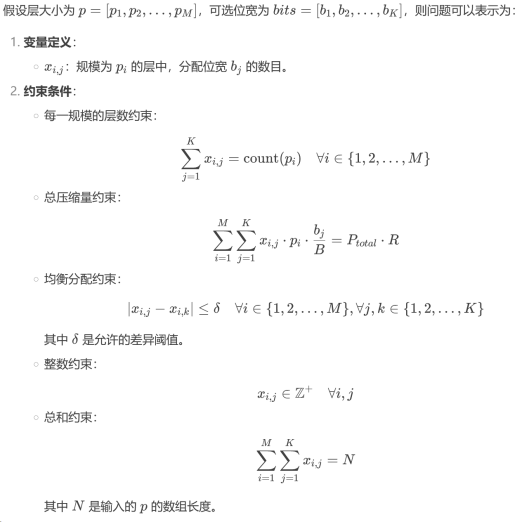
* 再按照fisher_info的大小排序实现位宽的分配
* 约束条件：
  * 均衡分配：确保每个规模的位宽分配尽可能均衡
  * 整数约束：求解的$x_{i,j}$​ 为正整数
  * 确保所有 $x_{i,j}$​​ 的总和等于输入的 p 的数组长度
 
优化
* 初始化：满足最低子群标准
* 逐步优化：贪心精度提高方向

In [55]:
from scipy.optimize import linprog
from collections import defaultdict
import numpy as np

def preallocate_bit_counts(p, R, bits=[2, 4, 8], B=16, delta=10):
    # 统计每一规模的层数
    size_counts = defaultdict(int)
    for size in p:
        size_counts[size] += 1

    # 计算目标总压缩量
    P_total = sum(p)
    target_compression = P_total * R

    M = len(size_counts)  # 不同规模的种类数
    K = len(bits)  # 可选位宽的数量
    N = len(p)  # 输入的 p 的数组长度

    c = [0] * (M * K)

    # 定义约束条件
    A_eq = []
    b_eq = []

    # 每一规模的层数约束
    for i, size in enumerate(size_counts):
        row = [0] * (M * K)
        for j in range(K):
            row[i * K + j] = 1
        A_eq.append(row)
        b_eq.append(size_counts[size])

    # 总压缩量约束
    row = []
    for i, size in enumerate(size_counts):
        for j, b in enumerate(bits):
            row.append(size * (b / B))
    A_eq.append(row)
    b_eq.append(target_compression)

    # 总和约束
    row = [1] * (M * K)
    A_eq.append(row)
    b_eq.append(N)

    # 均衡分配约束
    A_ub = []
    b_ub = []
    for i, size in enumerate(size_counts):
        for j in range(K):
            for k in range(K):
                if j != k:
                    row = [0] * (M * K)
                    row[i * K + j] = 1
                    row[i * K + k] = -1
                    A_ub.append(row)
                    b_ub.append(delta)
                    row = [0] * (M * K)
                    row[i * K + j] = -1
                    row[i * K + k] = 1
                    A_ub.append(row)
                    b_ub.append(delta)

    bounds = [(0, None)] * (M * K)

    result = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    if result.success:
        x = result.x
        bit_counts = {}
        for i, size in enumerate(size_counts):
            bit_counts[size] = {}
            for j, b in enumerate(bits):
                bit_counts[size][b] = int(round(x[i * K + j]))  # 四舍五入为整数
        return bit_counts
    else:
        raise ValueError("No solution found.")

In [72]:
def greedy_bit_allocation(p, F, bit_counts, bits=[2, 4, 8]):
    from collections import defaultdict

    size_to_indices = defaultdict(list)
    for idx, size in enumerate(p):
        size_to_indices[size].append(idx)

    for size in size_to_indices:
        size_to_indices[size].sort(key=lambda i: F[i], reverse=True)

    bit_allocation = [0] * len(p)

    for size, indices in size_to_indices.items():
        counts = bit_counts[size]
        # 分配位宽
        for b in sorted(bits, reverse=True):  
            while counts[b] > 0 and indices:
                idx = indices.pop(0)  
                bit_allocation[idx] = b
                counts[b] -= 1

    return bit_allocation

In [73]:
import numpy as np
import random
import json

def load_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

bits = [2, 3, 4, 8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
B = 16 
R = 0.25
delta = 10
bit_counts = preallocate_bit_counts(p, R, bits, B, delta)
print(bit_counts)
print(greedy_bit_allocation(p, F, bit_counts, bits))

{16777216: {2: 38, 3: 34, 4: 28, 8: 28}, 45088768: {2: 29, 3: 19, 4: 29, 8: 19}}
[8, 8, 8, 8, 8, 8, 4, 8, 4, 4, 4, 8, 8, 2, 4, 8, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 4, 8, 8, 8, 8, 8, 4, 3, 4, 4, 8, 8, 8, 4, 4, 8, 4, 4, 8, 4, 4, 3, 8, 4, 4, 3, 4, 3, 3, 4, 4, 4, 2, 2, 3, 3, 4, 3, 4, 3, 3, 2, 2, 4, 3, 3, 8, 8, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 2, 4, 2, 4, 4, 4, 2, 4, 3, 2, 3, 4, 3, 4, 4, 4, 2, 2, 4, 4, 2, 4, 3, 3, 8, 8, 4, 2, 3, 3, 3, 4, 8, 4, 2, 3, 3, 3, 8, 8, 8, 3, 4, 4, 3, 2, 3, 3, 2, 8, 8, 2, 2, 4, 3, 2, 8, 8, 2, 2, 4, 2, 2, 8, 4, 4, 4, 3, 3, 2, 2, 8, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 4, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### 贪心算法
优化目标： $\min_{\{bit_i\}}\sum_{i=1}^{N}F_i\cdot e^{-\alpha (B/bit_i)} \quad \text{subject to } \sum_{i=1}^{N}p_i\cdot \frac{bit_i}{B} \le P_{comp}$

贪心更新策略：在每一步中，**选择能够最大程度减少目标函数的层**，增加其量化位宽。
* 对于每一层，计算如果将其量化位宽从当前值增加到下一个更高的值（例如从2到4），目标函数的变化量
    * $\Delta_i = F_i\cdot (e^{-\alpha (B/bit_i^{new})} - e^{-\alpha (B/bit_i^{current})}) $
* 选择 $\Delta_i$ 最大的层，增加其量化位宽。同时更新当前 $P_{comp}^{new} = P_{comp}^{current} + p_i \cdot \frac{bit_i^{new}-bit_i^{current}}{B}$  
* 检查是否仍然满足压缩率 $R$ 的要求。如果满足，继续；否则，回退并选择下一个最优的层。

In [31]:
def greedy_bit_allocation(N, bits, F, p, B, R, alpha):
    # 初始化
    bit_allocation = [min(bits)] * N
    P_total = sum(p)
    P_current = sum(p_i * (bit_i / B) for p_i, bit_i in zip(p, bit_allocation))
    
    while True:
        # 计算当前目标函数值
        current_objective = sum(F_i * math.exp(-alpha * (B / bit_i)) for F_i, bit_i in zip(F, bit_allocation))
        
        # 寻找最优的层进行位宽增加
        best_delta = -float('inf')
        best_layer = -1
        best_new_bit = -1
        
        for i in range(N):
            current_bit = bit_allocation[i]
            if current_bit < max(bits):
                # 找到下一个更高的位宽
                next_bit = min([b for b in bits if b > current_bit])
                # 计算目标函数的变化量
                delta = F[i] * (math.exp(-alpha * (B / next_bit)) - math.exp(-alpha * (B / current_bit)))
                if delta > best_delta:
                    best_delta = delta
                    best_layer = i
                    best_new_bit = next_bit
        
        # 如果没有可以增加的层，终止
        if best_layer == -1:
            break
        
        # 尝试增加位宽
        new_P_current = P_current + p[best_layer] * ((best_new_bit - bit_allocation[best_layer]) / B)
        
        # 检查是否满足压缩率约束
        if new_P_current <= P_total * R:
            # 更新位宽和总参数规模
            bit_allocation[best_layer] = best_new_bit
            P_current = new_P_current
        else:
            # 无法增加，终止
            break
    
    return bit_allocation

In [1]:
def greedy_bit_allocation(N, bits, F, p, B, R, alpha, k):
    # 初始化
    bit_allocation = [min(bits)] * N
    P_total = sum(p)
    P_current = sum(p_i * (bit_i / B) for p_i, bit_i in zip(p, bit_allocation))
    
    # 目标函数计算
    def compute_objective(bit_allocation):
        return sum(F_i * math.exp(-alpha * (B / bit_i)) for F_i, bit_i in zip(F, bit_allocation))
    
    # 主循环
    while True:
        current_objective = compute_objective(bit_allocation)
        
        # 计算所有层的得分
        scores = []
        for i in range(N):
            current_bit = bit_allocation[i]
            if current_bit < max(bits):
                # 找到下一个更高的位宽
                next_bit = min([b for b in bits if b > current_bit])
                # 计算敏感度增量
                delta = F[i] * (math.exp(-alpha * (B / next_bit)) - math.exp(-alpha * (B / current_bit)))
                # 计算得分
                # score = delta * p[i]
                score = delta
                scores.append((score, i, next_bit))
            else:
                scores.append((0, i, current_bit))  # 无法增加位宽
        
        # 如果没有可以增加的层，终止
        if all(score == 0 for score, _, _ in scores):
            break
        
        # 选择得分前 k 大的层
        top_k = sorted(scores, key=lambda x: x[0], reverse=True)[:k]
        
        # 生成 k 个候选状态
        candidates = []
        for score, i, next_bit in top_k:
            new_bit_allocation = bit_allocation.copy()
            new_bit_allocation[i] = next_bit
            new_P_current = P_current + p[i] * ((next_bit - bit_allocation[i]) / B)
            if new_P_current <= P_total * R:
                candidates.append((new_bit_allocation, new_P_current))
        
        if not candidates:
            break
        
        best_candidate = min(candidates, key=lambda x: compute_objective(x[0]))
        bit_allocation, P_current = best_candidate
    
    return bit_allocation

In [2]:
def recursive_greedy_bit_allocation(N, bits, F, p, B, R, alpha, k, max_depth):
    # 初始化
    initial_bit_allocation = [min(bits)] * N
    P_total = sum(p)
    initial_P_current = sum(p_i * (bit_i / B) for p_i, bit_i in zip(p, initial_bit_allocation))
    
    # 目标函数计算
    def compute_objective(bit_allocation):
        return sum(F_i * math.exp(-alpha * (B / bit_i)) for F_i, bit_i in zip(F, bit_allocation))
    
    # 递归函数
    def recursive_search(bit_allocation, P_current, depth):
        # 终止条件：无法进一步增加位宽
        if depth >= max_depth or P_current >= P_total * R:
            return bit_allocation, compute_objective(bit_allocation)
        
        # 计算所有层的得分
        scores = []
        for i in range(N):
            current_bit = bit_allocation[i]
            if current_bit < max(bits):
                # 找到下一个更高的位宽
                next_bit = min([b for b in bits if b > current_bit])
                # 计算敏感度增量
                delta = F[i] * (math.exp(-alpha * (B / next_bit)) - math.exp(-alpha * (B / current_bit)))
                # 计算得分
                # score = delta * p[i]
                score = delta
                scores.append((score, i, next_bit))
            else:
                scores.append((0, i, current_bit))  # 无法增加位宽
        
        # 如果没有可以增加的层，终止
        if all(score == 0 for score, _, _ in scores):
            return bit_allocation, compute_objective(bit_allocation)
        
        # 选择得分前 k 大的层
        top_k = sorted(scores, key=lambda x: x[0], reverse=True)[:k]
        
        # 递归扩展 k 个分支
        best_bit_allocation = bit_allocation
        best_objective = compute_objective(bit_allocation)
        
        for score, i, next_bit in top_k:
            new_bit_allocation = bit_allocation.copy()
            new_bit_allocation[i] = next_bit
            new_P_current = P_current + p[i] * ((next_bit - bit_allocation[i]) / B)
            
            # 剪枝：如果超过压缩率约束，跳过
            if new_P_current > P_total * R:
                continue
            
            # 递归调用
            candidate_bit_allocation, candidate_objective = recursive_search(new_bit_allocation, new_P_current, depth + 1)
            
            # 更新最优解
            if candidate_objective < best_objective:
                best_bit_allocation = candidate_bit_allocation
                best_objective = candidate_objective
        
        return best_bit_allocation, best_objective
    
    # 开始递归搜索
    best_bit_allocation, _ = recursive_search(initial_bit_allocation, initial_P_current, 0)
    return best_bit_allocation

In [ ]:
import numpy as np
import random
import json
import math

def load_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

def evaluate(F,B):
    alpha = 3
    original_b = 16
    objective = sum(F[i] * np.exp(-alpha * (original_b / B[i])) for i in range(len(F)))
    print(objective)

bits = [2, 3, 4, 8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F) 
B = 16 
R = 0.25
alpha = 0.9  #量化位宽影响系数
k = 20
max_depth = 80

res0 = greedy_bit_allocation(N, bits, F, p, B, R, alpha, k)
print(res0)
print(evaluate(F,res0))

res1 = recursive_greedy_bit_allocation(N, bits, F, p, B, R, alpha, 2, max_depth)
print(res1)
print(evaluate(F,res1))

[4, 4, 4, 4, 4, 8, 2, 4, 8, 8, 2, 3, 4, 2, 8, 8, 8, 2, 4, 4, 2, 8, 8, 8, 2, 4, 4, 8, 8, 4, 2, 8, 8, 8, 8, 8, 4, 2, 2, 8, 8, 8, 4, 4, 2, 2, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 2, 8, 2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8, 2, 2, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 2, 8, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 8, 2, 2, 8, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 2, 8, 2, 2, 2, 2, 2, 2, 8, 4, 2, 2, 8, 2, 2, 8, 8, 2, 2, 4, 2, 2, 4, 8, 2, 8, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
2.791178819738089
None


In [9]:
import numpy as np
import random
import json
import math

def load_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

bits = [2, 3, 4, 8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F) 
B = 16 
R = 0.25
alpha = 0.01  #量化位宽影响系数
print(greedy_bit_allocation(N, bits, F, p, B, R, alpha))

[8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 2, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2]


In [47]:
import numpy as np
import random
import json
import math

def load_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

bits = [2, 3, 8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F) 
B = 16 
R = 0.25
alpha = 0.01  #量化位宽影响系数
print(greedy_bit_allocation(N, bits, F, p, B, R, alpha))

[8, 8, 8, 8, 8, 8, 2, 8, 2, 8, 2, 8, 8, 2, 2, 8, 8, 2, 8, 8, 2, 8, 8, 8, 2, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 8, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 8, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 8, 2, 8, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [67]:
import matplotlib.pyplot as plt

F = [30.046875, 98.375, 41.09375, 26.90625, 32.875, 19.6875, 15.859375, 491.0, 16.390625, 17.46875, 15.3046875, 248.5, 22.46875, 13.6015625, 16.390625, 19.625, 20.90625, 15.1015625, 32.0, 23.9375, 15.21875, 17.828125, 18.640625, 17.71875, 13.6640625, 39.84375, 27.046875, 19.03125, 19.078125, 22.78125, 15.8046875, 16.625, 22.453125, 19.5, 20.21875, 18.265625, 22.515625, 14.96875, 14.3046875, 17.734375, 17.390625, 20.0, 30.640625, 25.15625, 15.234375, 14.9765625, 22.40625, 17.59375, 16.890625, 20.65625, 16.859375, 15.3203125, 13.40625, 19.65625, 16.859375, 17.453125, 14.21875, 16.390625, 14.796875, 13.9140625, 18.296875, 18.25, 17.609375, 10.75, 11.546875, 14.7421875, 13.7265625, 17.34375, 15.515625, 15.6171875, 13.6875, 13.828125, 12.4453125, 12.4921875, 16.015625, 15.4140625, 14.8515625, 18.46875, 18.359375, 13.28125, 14.15625, 15.4140625, 13.9296875, 14.96875, 11.4921875, 12.3828125, 12.203125, 12.4765625, 14.6484375, 15.2265625, 14.9453125, 12.6484375, 13.8359375, 11.5390625, 12.4375, 14.9921875, 14.875, 14.734375, 14.375, 14.7265625, 11.6015625, 12.1796875, 14.7265625, 14.15625, 14.5703125, 8.875, 9.515625, 12.109375, 11.8203125, 15.3359375, 14.2734375, 14.734375, 12.9921875, 14.3203125, 12.9453125, 14.1875, 16.9375, 16.453125, 16.453125, 13.03125, 16.328125, 12.859375, 13.6640625, 16.46875, 15.8203125, 15.6796875, 11.8125, 15.0625, 12.3671875, 15.4453125, 17.109375, 15.9765625, 14.5390625, 15.1015625, 13.609375, 12.21875, 14.4453125, 18.34375, 15.359375, 15.6171875, 15.7421875, 17.390625, 12.484375, 12.03125, 17.515625, 15.7265625, 13.25, 16.25, 14.046875, 14.0078125, 20.84375, 19.375, 15.9140625, 14.546875, 13.84375, 13.8125, 14.0, 16.5625, 19.921875, 16.3125, 13.4921875, 14.53125, 13.953125, 13.859375, 17.53125, 21.53125, 18.484375, 15.2421875, 16.34375, 14.9375, 13.0859375, 10.9765625, 14.9609375, 15.3125, 14.25, 18.8125, 28.59375, 12.640625, 8.8828125, 18.21875, 14.890625, 12.890625, 17.953125, 20.34375, 12.5234375, 12.6484375, 15.9609375, 11.90625, 12.6640625, 48.34375, 16.71875, 15.859375, 17.484375, 15.5078125, 15.609375, 13.671875, 12.640625, 27.515625, 12.046875, 10.125, 13.2109375, 11.8359375, 11.0078125, 15.1640625, 11.828125, 13.5625, 12.5703125, 9.984375, 10.828125, 10.3046875, 15.6953125, 17.609375, 11.515625, 10.109375, 10.2890625, 8.6796875, 9.9609375, 10.8984375, 9.9140625, 10.859375, 10.953125, 8.390625, 9.609375, 8.7890625]
B = [8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 2, 3, 8, 8, 2, 8, 8, 2, 8, 8, 8, 2, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 2, 2, 8, 8, 3, 8, 3, 3, 2, 8, 3, 8, 2, 3, 2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 3, 3, 2, 2, 2, 2, 3, 3, 2, 8, 8, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 8, 3, 2, 2, 2, 2, 2, 8, 3, 3, 3, 8, 2, 2, 8, 3, 2, 3, 2, 2, 8, 8, 3, 2, 2, 2, 2, 3, 8, 3, 2, 2, 2, 2, 8, 8, 8, 2, 3, 2, 2, 2, 2, 3, 2, 8, 8, 2, 2, 8, 2, 2, 8, 8, 2, 2, 3, 2, 2, 8, 3, 3, 8, 3, 3, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
B2 = [8, 8, 8, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 2, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2]
B3 = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 2, 8, 4, 4, 2, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 2, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 2, 8, 8, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 8, 2, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 8, 2, 2, 2, 4, 4, 8, 4, 2, 4, 4, 2, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 8, 4, 4, 4, 4, 4, 4, 8, 2, 4, 8, 4, 4, 4, 4, 4, 8, 8, 2, 4, 4, 4, 2, 4, 8, 4, 2, 4, 2, 2, 4, 2, 2, 4, 2, 4, 4, 4, 8, 4, 4, 2, 4, 2, 8, 4, 4, 2, 4, 2, 4, 2, 2, 2, 4, 4, 4, 2, 8, 2]
B4 = [8, 8, 8, 8, 8, 8, 2, 8, 2, 8, 2, 8, 8, 2, 2, 8, 8, 2, 8, 8, 2, 8, 8, 8, 2, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 8, 8, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 8, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 2, 2, 8, 2, 2, 8, 8, 2, 2, 2, 2, 2, 8, 8, 2, 8, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [68]:
import numpy as np
def evaluate(F,B):
    alpha = 3
    original_b = 16
    objective = sum(F[i] * np.exp(-alpha * (original_b / B[i])) for i in range(len(F)))
    print(objective)

In [62]:
evaluate(F,B)
evaluate(F,B2)
evaluate(F,B3)
evaluate(F,B4)

5.279198137673911
4.447972327179669
0.7390701136098283
5.570261569882265


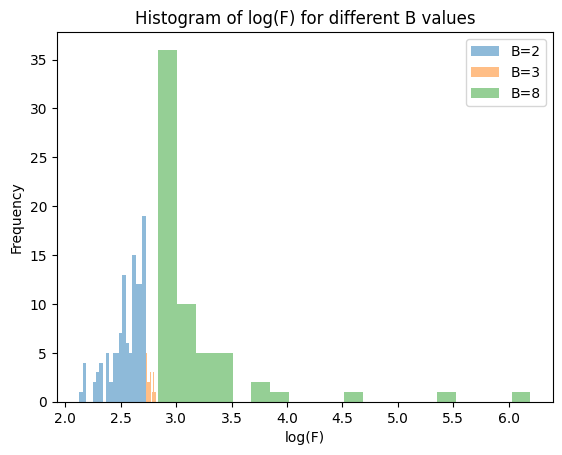

In [70]:
import numpy as np

log_F = np.log(F)

# 按B的值分组
unique_B = np.unique(B4)
for b in unique_B:
    plt.hist([log_F[i] for i, f in enumerate(F) if B[i] == b], bins=20, alpha=0.5, label=f'B={b}')

plt.xlabel('log(F)')
plt.ylabel('Frequency')
plt.title('Histogram of log(F) for different B values')
plt.legend()
plt.show()

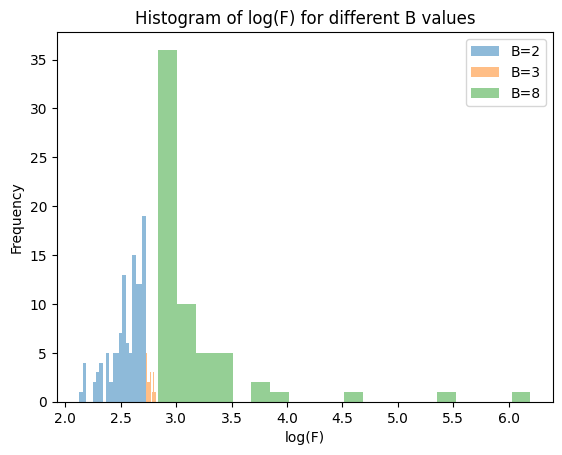

In [66]:
import numpy as np

log_F = np.log(F)

# 按B的值分组
unique_B = np.unique(B)
for b in unique_B:
    plt.hist([log_F[i] for i, f in enumerate(F) if B[i] == b], bins=20, alpha=0.5, label=f'B={b}')

plt.xlabel('log(F)')
plt.ylabel('Frequency')
plt.title('Histogram of log(F) for different B values')
plt.legend()
plt.show()

## 模拟退火策略

In [8]:
import numpy as np
import random
import json
import math
from scipy.optimize import dual_annealing

def load_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)


bits = [3,4,8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F) 
B = 16  # 原始位宽
R = 0.25  # 压缩率
alpha = 1  # 目标函数参数
P_total = np.sum(p)  # 总参数规模

# 将连续变量映射到离散位宽
def map_to_discrete(continuous_value):
    return min(bits, key=lambda x: abs(x - continuous_value))

# 目标函数
def objective_function(bit_allocation):
    # 将连续变量映射到离散位宽
    bit_allocation = np.array([map_to_discrete(bit) for bit in bit_allocation])
    
    # 计算目标函数值
    objective = np.sum(F * np.exp(-alpha * (B / bit_allocation)))
    
    # 计算压缩率约束
    compressed_size = np.sum(p * (bit_allocation / B))
    constraint = compressed_size - P_total * R
    
    # 添加惩罚项（如果约束不满足）
    penalty = 1e6 * max(0, abs(constraint))  # 惩罚系数
    return objective + penalty

# 变量的上下界（每层的量化位宽范围）
bounds = [(min(bits), max(bits)) for _ in range(N)]

# 调用模拟退火算法
result = dual_annealing(objective_function, bounds, maxiter=1000, seed=42)

# 输出结果
optimal_bit_allocation = np.array([map_to_discrete(bit) for bit in result.x])
print("最优位宽分配:", optimal_bit_allocation)
print("目标函数值:", result.fun)
c = sum(p[i] * (optimal_bit_allocation[i] / B) for i in range(N))/P_total
print("Best individual compression:", c)

最优位宽分配: [4 4 4 3 4 4 4 8 3 4 4 4 4 3 3 3 4 3 4 3 3 4 4 3 4 4 3 4 4 4 8 4 3 4 3 3 4
 4 3 4 3 4 4 3 8 4 3 4 4 4 4 4 4 3 4 3 4 3 4 8 4 4 4 4 3 4 4 3 3 4 4 4 3 4
 4 3 4 3 4 4 4 3 3 3 3 4 4 4 3 3 4 4 4 4 8 4 4 4 4 3 8 4 4 4 4 4 3 4 4 3 4
 4 4 4 3 4 3 4 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 3 4 3 3 3 3 4 4 4 4 3 3 3 3 4
 4 3 4 4 4 4 3 4 4 4 8 4 4 3 4 4 3 3 8 4 4 8 4 8 3 8 3 4 4 3 4 4 3 8 4 3 4
 8 4 4 4 4 4 3 8 4 4 3 8 4 4 4 3 4 8 4 3 4 8 4 4 4 4 3 3 4 4 4 8 3 8 4 3 8
 3 3]
目标函数值: 196608000152.68497
Best individual compression: 0.25003035945595853


## 强化学习方案（单层更新策略）

In [20]:
import itertools

class GlobalBitwidthAllocationEnv:
    def __init__(self, N, F, p, B, P_total, R, alpha, beta=1.0, bits=[2, 4, 8]):
        self.N = N
        self.F = F
        self.p = p
        self.B = B
        self.P_total = P_total
        self.R = R
        self.alpha = alpha
        self.beta = beta
        self.bits = bits
        self.action_space = list(itertools.product(bits, repeat=N))  # 所有可能的位宽组合
        self.reset()

    def reset(self):
        """重置环境状态"""
        self.current_compression = 0
        self.current_objective = 0
        return self._get_state()

    def _get_state(self):
        """获取当前状态"""
        return np.array([self.current_compression, self.current_objective])

    def step(self, action):
        """
        执行动作
        :param action: 位宽分配方案 (tuple of length N)
        :return: next_state, reward, done, info
        """
        total_compression = 0
        total_objective = 0
        for i in range(self.N):
            bit = action[i]
            compression = self.p[i] * (bit / self.B)
            total_compression += compression
            objective = self.F[i] * np.exp(-self.alpha * (self.B / bit))
            total_objective += objective

        # 计算奖励
        if total_compression > self.P_total * self.R:
            penalty = self.beta * (total_compression - self.P_total * self.R)
            reward = -total_objective - penalty
        else:
            reward = -total_objective

        self.current_compression = total_compression
        self.current_objective = total_objective
        done = True  # 每次决策都是一个完整的位宽分配方案
        next_state = self._get_state()
        info = {}
        return next_state, reward, done, info

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# 环境定义
class GlobalBitwidthAllocationEnv:
    def __init__(self, N, F, p, B, P_total, R, alpha, beta=1.0, bits=[2, 4, 8]):
        self.N = N
        self.F = F
        self.p = p
        self.B = B
        self.P_total = P_total
        self.R = R
        self.alpha = alpha
        self.beta = beta
        self.bits = bits
        self.reset()

    def reset(self):
        """重置环境状态"""
        self.current_compression = 0
        self.current_objective = 0
        return self._get_state()

    def _get_state(self):
        """获取当前状态"""
        return np.array([self.current_compression, self.current_objective])

    def sample_action(self):
        """分层采样动作"""
        action = []
        for i in range(self.N):
            if self.F[i] > np.median(self.F):  # 高敏感度层
                action.append(np.random.choice([4, 8]))  # 选择较高位宽
            else:  # 低敏感度层
                action.append(np.random.choice([2, 4]))  # 选择较低位宽
        return action

    def step(self, action):
        """
        执行动作
        :param action: 位宽分配方案 (list of length N)
        :return: next_state, reward, done, info
        """
        total_compression = 0
        total_objective = 0
        for i in range(self.N):
            bit = action[i]
            compression = self.p[i] * (bit / self.B)
            total_compression += compression
            objective = self.F[i] * np.exp(-self.alpha * (self.B / bit))
            total_objective += objective

        # 计算奖励
        if total_compression > self.P_total * self.R:
            penalty = self.beta * (total_compression - self.P_total * self.R)
            reward = -total_objective - penalty
        else:
            reward = -total_objective

        self.current_compression = total_compression
        self.current_objective = total_objective
        done = True  # 每次决策都是一个完整的位宽分配方案
        next_state = self._get_state()
        info = {}
        return next_state, reward, done, info

In [19]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [20]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=10000)
        self.model = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_model = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def act(self, state):
        """选择动作"""
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.FloatTensor(state)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        """存储经验"""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        """训练模型"""
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # 计算目标 Q 值
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        next_q = self.target_model(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # 计算损失并更新模型
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 更新探索率
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        """更新目标网络"""
        self.target_model.load_state_dict(self.model.state_dict())

In [ ]:
import random
import json
import numpy as np

def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

# 参数设置
bits = [2, 3, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 3  # 目标函数中的衰减系数
beta=1 # 惩罚项系数

# 初始化环境和智能体
env = GlobalBitwidthAllocationEnv(N, F, p, B, P_total, R, alpha, bits)
state_dim = 2  # 状态维度（压缩率和目标函数值）
action_dim = len(bits) ** N  # 动作维度（所有可能的位宽组合）
agent = DQNAgent(state_dim, action_dim)

# 训练
episodes = 1000
batch_size = 32
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(env.sample_action())
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    agent.replay(batch_size)
    if episode % 10 == 0:
        agent.update_target_model()
        print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

# 测试
state = env.reset()
done = False
while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(env.sample_action())
    state = next_state
    print(f"Action: {env.sample_action()}, Compression: {env.current_compression}, Objective: {env.current_objective}")

## 强化学习方案(完全层更新)
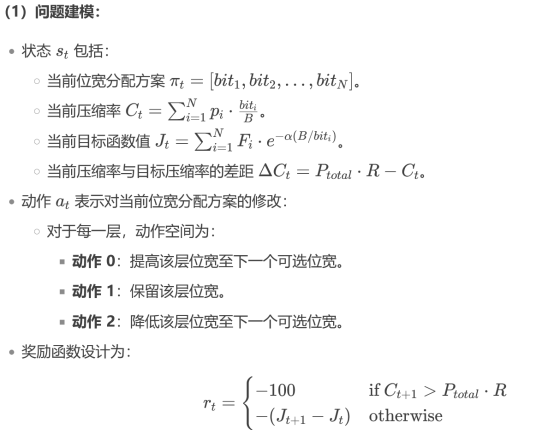

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# 定义策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

# 定义值函数网络
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# PPO 算法
class PPO:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, clip_epsilon=0.2):
        self.policy_network = PolicyNetwork(state_dim, action_dim)
        self.value_network = ValueNetwork(state_dim)
        self.optimizer = optim.Adam(list(self.policy_network.parameters()) + list(self.value_network.parameters()), lr=lr)
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon

    def select_action(self, state):
        state = torch.FloatTensor(state)
        action_probs = self.policy_network(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        return action.item(), action_dist.log_prob(action)

    def compute_returns(self, rewards, dones, values, next_value):
        returns = np.zeros_like(rewards)
        advantages = np.zeros_like(rewards)
        R = next_value
        for t in reversed(range(len(rewards))):
            R = rewards[t] + self.gamma * R * (1 - dones[t])
            returns[t] = R
            advantages[t] = R - values[t]
        return returns, advantages

    def update(self, states, actions, log_probs_old, returns, advantages):
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        log_probs_old = torch.FloatTensor(log_probs_old)
        returns = torch.FloatTensor(returns)
        advantages = torch.FloatTensor(advantages)

        # 计算新的动作概率和值函数
        action_probs = self.policy_network(states)
        action_dist = torch.distributions.Categorical(action_probs)
        log_probs_new = action_dist.log_prob(actions)
        values = self.value_network(states).squeeze()

        # 计算策略损失
        ratio = torch.exp(log_probs_new - log_probs_old)
        clipped_ratio = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
        policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()

        # 计算值函数损失
        value_loss = nn.MSELoss()(values, returns)

        # 更新网络
        self.optimizer.zero_grad()
        (policy_loss + value_loss).backward()
        self.optimizer.step()

# 定义目标评估函数
def evaluate_objective(F, bit_widths, alpha, B):
    return sum(F_i * np.exp(-alpha * (B / bit_i)) for F_i, bit_i in zip(F, bit_widths))

# 定义压缩率计算函数
def compute_compression_rate(p, bit_widths, B, P_total, R):
    return sum(p_i * (bit_i / B) for p_i, bit_i in zip(p, bit_widths)) <= P_total * R

# 定义初始状态
def initialize_state(F, p, B, P_total, R):
    bit_widths = [8] * N  # 初始位宽分配方案
    compression_rate = sum(p_i * (bit_i / B) for p_i, bit_i in zip(p, bit_widths))
    objective_value = evaluate_objective(F, bit_widths, alpha=1.0, B=B)
    delta_compression = P_total * R - compression_rate
    state = bit_widths + [compression_rate, objective_value, delta_compression]
    return state

# 定义执行动作函数
def execute_action(state, action, F, p, B, P_total, R):
    bit_widths = state[:N]
    layer_to_modify = np.random.randint(0, N)  # 随机选择一层进行修改
    current_bit = bit_widths[layer_to_modify]

    if action == 0:  # 提高位宽
        if current_bit < 8:
            bit_widths[layer_to_modify] = min(current_bit + 2, 8)
    elif action == 2:  # 降低位宽
        if current_bit > 2:
            bit_widths[layer_to_modify] = max(current_bit - 2, 2)

    # 计算新的状态
    compression_rate = sum(p_i * (bit_i / B) for p_i, bit_i in zip(p, bit_widths))
    objective_value = evaluate_objective(F, bit_widths, alpha=1.0, B=B)
    delta_compression = P_total * R - compression_rate

    # 计算奖励
    if compression_rate > P_total * R:
        reward = -100  # 压缩率超过约束
    else:
        reward = -(objective_value - state[N + 1])  # 目标函数值的改进

    # 返回新的状态和奖励
    next_state = bit_widths + [compression_rate, objective_value, delta_compression]
    done = delta_compression < 1e-3  # 如果压缩率接近目标，则结束
    return next_state, reward, done


In [24]:
import random
import json
import numpy as np

def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

# 参数设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bits = [2, 3, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 3  # 目标函数中的衰减系数

# 初始化参数
state_dim = N + 3  # N 层位宽 + 压缩率 + 目标函数值 + 压缩率差距
action_dim = 3     # 每个层有 3 种动作
ppo_agent = PPO(state_dim, action_dim)

# 训练过程
num_episodes = 1000
max_steps = 100
batch_size = 32

for episode in range(num_episodes):
    state = initialize_state(F, p, B, P_total, R)
    states, actions, log_probs, rewards, dones, values = [], [], [], [], [], []

    for t in range(max_steps):
        # 选择动作
        action, log_prob = ppo_agent.select_action(state)
        next_state, reward, done = execute_action(state, action, F, p, B, P_total, R)

        # 存储经验
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob.item())
        rewards.append(reward)
        dones.append(done)
        values.append(ppo_agent.value_network(torch.FloatTensor(state)).item())

        # 更新状态
        state = next_state

        # 如果 episode 结束，提前退出
        if done:
            break

    # 计算回报和优势
    next_value = ppo_agent.value_network(torch.FloatTensor(next_state)).item()
    returns, advantages = ppo_agent.compute_returns(rewards, dones, values, next_value)

    # 更新策略网络和值函数网络
    ppo_agent.update(states, actions, log_probs, returns, advantages)

    # 打印训练进度
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}, Total Reward: {sum(rewards)}")

# 测试过程
def test_policy(ppo_agent, initial_state):
    state = initial_state
    done = False
    total_reward = 0

    while not done:
        action, _ = ppo_agent.select_action(state)
        next_state, reward, done = execute_action(state, action)
        total_reward += reward
        state = next_state

    return total_reward

# 测试最优策略
initial_state = initialize_state(F, p, B, P_total, R)
total_reward = test_policy(ppo_agent, initial_state, F, p, B, P_total, R)
print(f"Test Total Reward: {total_reward}")

/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 10, Total Reward: -100
Episode 20, Total Reward: -100
Episode 30, Total Reward: -100
Episode 40, Total Reward: -100
Episode 50, Total Reward: -100
Episode 60, Total Reward: -100
Episode 70, Total Reward: -100
Episode 80, Total Reward: -100
Episode 90, Total Reward: -100
Episode 100, Total Reward: -100
Episode 110, Total Reward: -100
Episode 120, Total Reward: -100
Episode 130, Total Reward: -100
Episode 140, Total Reward: -100
Episode 150, Total Reward: -100
Episode 160, Total Reward: -100
Episode 170, Total Reward: -100
Episode 180, Total Reward: -100
Episode 190, Total Reward: -100
Episode 200, Total Reward: -100
Episode 210, Total Reward: -100
Episode 220, Total Reward: -100
Episode 230, Total Reward: -100
Episode 240, Total Reward: -100
Episode 250, Total Reward: -100
Episode 260, Total Reward: -100
Episode 270, Total Reward: -100
Episode 280, Total Reward: -100
Episode 290, Total Reward: -100
Episode 300, Total Reward: -100
Episode 310, Total Reward: -100
Episode 320, Tota

TypeError: test_policy() takes 2 positional arguments but 7 were given

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# 定义 Q 网络
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

import random
import json
import numpy as np

def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

# 参数设置
bits = [2, 3, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 3  # 目标函数中的衰减系数

state_dim = N + 3  # 状态维度
action_dim = 3  # 动作维度
q_network = QNetwork(state_dim, action_dim)
target_network = QNetwork(state_dim, action_dim)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=1e-3)
replay_buffer = deque(maxlen=10000)
epsilon = 1.0
gamma = 0.99
tau = 100
batch_size = 32
num_episodes = 1000
max_steps = 100
decay_rate = 0.995


# 定义目标函数
def compute_objective(bit_allocation):
    return np.sum(F * np.exp(-alpha * (B / bit_allocation)))

# 定义压缩率
def compute_compression(bit_allocation):
    return np.sum(p * (bit_allocation / B))

# 定义执行动作
def execute_action(state, action):
    bit_allocation = state[:N]
    layer = np.random.randint(N)  # 随机选择一层
    current_bit = bit_allocation[layer]
    if action == 0 and current_bit < max(bits):  # 提高位宽
        bit_allocation[layer] = bits[bits.index(current_bit) + 1]
    elif action == 2 and current_bit > min(bits):  # 降低位宽
        bit_allocation[layer] = bits[bits.index(current_bit) - 1]
    # 计算新的状态
    C_t_plus_1 = compute_compression(bit_allocation)
    J_t_plus_1 = compute_objective(bit_allocation)
    next_state = np.concatenate([bit_allocation, [C_t_plus_1, J_t_plus_1, P_total * R - C_t_plus_1]])
    # 计算奖励
    if C_t_plus_1 > P_total * R:
        reward = -100
    else:
        reward = -(J_t_plus_1 - state[-2])
    return next_state, reward

# 训练过程
for episode in range(num_episodes):
    # 初始化状态
    bit_allocation = np.random.choice(bits, size=N)  # 随机初始化位宽分配
    C_t = compute_compression(bit_allocation)
    J_t = compute_objective(bit_allocation)
    state = np.concatenate([bit_allocation, [C_t, J_t, P_total * R - C_t]])
    
    for t in range(max_steps):
        # 选择动作
        if np.random.rand() < epsilon:
            action = np.random.choice(action_dim)
        else:
            q_values = q_network(torch.FloatTensor(state))
            action = torch.argmax(q_values).item()

        # 执行动作
        next_state, reward = execute_action(state, action)

        # 存储经验
        replay_buffer.append((state, action, reward, next_state))

        # 采样训练
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states = zip(*batch)
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)

            # 计算目标 Q 值
            next_q_values = target_network(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]
            target_q_values = rewards + gamma * max_next_q_values

            # 计算当前 Q 值
            current_q_values = q_network(states).gather(1, actions.unsqueeze(1))

            # 计算损失
            loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))

            # 更新 Q 网络
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 更新目标网络
        if t % tau == 0:
            target_network.load_state_dict(q_network.state_dict())

        # 衰减探索率
        epsilon *= decay_rate

        # 检查终止条件
        if abs(P_total * R - next_state[-3]) < 1e-3:  # 压缩率接近目标
            break

    # 打印训练进度
    if episode % 100 == 0:
        print(f"Episode {episode}, Epsilon {epsilon:.4f}, Objective {next_state[-2]:.4f}, state {state}")

# 测试训练好的模型
bit_allocation = np.random.choice(bits, size=N)  # 随机初始化位宽分配
C_t = compute_compression(bit_allocation)
J_t = compute_objective(bit_allocation)
state = np.concatenate([bit_allocation, [C_t, J_t, P_total * R - C_t]])

for t in range(max_steps):
    q_values = q_network(torch.FloatTensor(state))
    action = torch.argmax(q_values).item()
    next_state, reward = execute_action(state, action)
    state = next_state
    if abs(P_total * R - state[-3]) < 1e-3:  # 压缩率接近目标
        break

print("Final bit allocation:", state[:N])
print("Final compression rate:", state[-3] / P_total)
print("Final objective value:", state[-2])

Episode 0, Epsilon 0.6058, Objective 2.7836, state [ 2.00000000e+00  8.00000000e+00  3.00000000e+00  4.00000000e+00
  2.00000000e+00  3.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  3.00000000e+00  2.00000000e+00  4.00000000e+00
  2.00000000e+00  3.00000000e+00  8.00000000e+00  3.00000000e+00
  8.00000000e+00  2.00000000e+00  2.00000000e+00  8.00000000e+00
  8.00000000e+00  2.00000000e+00  8.00000000e+00  8.00000000e+00
  2.00000000e+00  2.00000000e+00  2.00000000e+00  8.00000000e+00
  2.00000000e+00  8.00000000e+00  4.00000000e+00  8.00000000e+00
  8.00000000e+00  3.00000000e+00  8.00000000e+00  8.00000000e+00
  8.00000000e+00  8.00000000e+00  8.00000000e+00  8.00000000e+00
  2.00000000e+00  8.00000000e+00  8.00000000e+00  4.00000000e+00
  2.00000000e+00  8.00000000e+00  4.00000000e+00  8.00000000e+00
  2.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  4.00000000e+00  3.00000000e+00
  4.00000000e+00  3.00000000e+00  3.000

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import json

# 定义 Q 网络
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)


def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)


# 参数设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bits = [2, 3, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 0.4  # 目标函数中的衰减系数

state_dim = N + 3  # 状态维度
action_dim = 3  # 动作维度
q_network = QNetwork(state_dim, action_dim).to(device)
target_network = QNetwork(state_dim, action_dim).to(device)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=1e-3)
replay_buffer = deque(maxlen=10000)
epsilon = 1.0
gamma = 0.99
tau = 100
batch_size = 32
num_episodes = 10000
max_steps = 100
decay_rate = 0.25


# 定义目标函数
def compute_objective(bit_allocation):
    return np.sum(F * np.exp(-alpha * (B / bit_allocation)))

# 定义压缩率
def compute_compression(bit_allocation):
    return np.sum(p * (bit_allocation / B))

# 定义执行动作
def execute_action(state, action):
    bit_allocation = state[:N]
    layer = np.random.randint(N)  # 随机选择一层
    current_bit = bit_allocation[layer]
    if action == 0 and current_bit < max(bits):  # 提高位宽
        bit_allocation[layer] = bits[bits.index(current_bit) + 1]
    elif action == 2 and current_bit > min(bits):  # 降低位宽
        bit_allocation[layer] = bits[bits.index(current_bit) - 1]
    # 计算新的状态
    C_t_plus_1 = compute_compression(bit_allocation)
    J_t_plus_1 = compute_objective(bit_allocation)
    next_state = np.concatenate([bit_allocation, [C_t_plus_1, J_t_plus_1, P_total * R - C_t_plus_1]])
    # 计算奖励
    if C_t_plus_1 > P_total * R:
        reward = -1000
    else:
        reward = -(J_t_plus_1 - state[-2])
    return next_state, reward

# 训练过程
for episode in range(num_episodes):
    # 初始化状态
    bit_allocation = np.random.choice(bits, size=N)  # 随机初始化位宽分配
    C_t = compute_compression(bit_allocation)
    J_t = compute_objective(bit_allocation)
    state = np.concatenate([bit_allocation, [C_t, J_t, P_total * R - C_t]])
    
    for t in range(max_steps):
        # 选择动作
        if np.random.rand() < epsilon:
            action = np.random.choice(action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # 将状态转换为 GPU 张量
            q_values = q_network(state_tensor)
            action = torch.argmax(q_values).item()

        next_state, reward = execute_action(state, action)

        replay_buffer.append((state, action, reward, next_state))

        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states = zip(*batch)
            
            # 将数据转换为 GPU 张量
            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).to(device)

            # 计算目标 Q 值
            next_q_values = target_network(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]
            target_q_values = rewards + gamma * max_next_q_values

            # 计算当前 Q 值
            current_q_values = q_network(states).gather(1, actions.unsqueeze(1))

            # 计算损失
            loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))

            # 更新 Q 网络
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 更新目标网络
        if t % tau == 0:
            target_network.load_state_dict(q_network.state_dict())

        # 衰减探索率
        epsilon *= decay_rate

        # 检查终止条件
        if abs(P_total * R - next_state[-3]) < 1e-3:  # 压缩率接近目标
            break

    # 打印训练进度
    if episode % 100 == 0:
        print(f"Episode {episode}, Epsilon {epsilon:.4f}, Objective {next_state[-2]:.4f}")

# 测试训练好的模型
bit_allocation = np.random.choice(bits, size=N)  # 随机初始化位宽分配
C_t = compute_compression(bit_allocation)
J_t = compute_objective(bit_allocation)
state = np.concatenate([bit_allocation, [C_t, J_t, P_total * R - C_t]])

for t in range(max_steps):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # 将状态转换为 GPU 张量
    q_values = q_network(state_tensor)
    action = torch.argmax(q_values).item()
    next_state, reward = execute_action(state, action)
    state = next_state
    if abs(P_total * R - state[-3]) < 1e-3:  # 压缩率接近目标
        break

print("Final bit allocation:", state[:N])
print("Final compression rate:", state[-3] / P_total)
print("Final objective value:", state[-2])

Episode 0, Epsilon 0.6058, Objective 980.5922
Episode 100, Epsilon 0.0000, Objective 980.6491
Episode 200, Epsilon 0.0000, Objective 704.9723
Episode 300, Epsilon 0.0000, Objective 912.7746
Episode 400, Epsilon 0.0000, Objective 1158.4725
Episode 500, Epsilon 0.0000, Objective 962.8401
Episode 600, Epsilon 0.0000, Objective 951.5981
Episode 700, Epsilon 0.0000, Objective 1141.1384
Episode 800, Epsilon 0.0000, Objective 1014.3650
Episode 900, Epsilon 0.0000, Objective 975.8519
Episode 1000, Epsilon 0.0000, Objective 1018.5487
Episode 1100, Epsilon 0.0000, Objective 1025.5220
Episode 1200, Epsilon 0.0000, Objective 1028.4669
Episode 1300, Epsilon 0.0000, Objective 970.1897
Episode 1400, Epsilon 0.0000, Objective 994.5794
Episode 1500, Epsilon 0.0000, Objective 1212.0446
Episode 1600, Epsilon 0.0000, Objective 1118.1003
Episode 1700, Epsilon 0.0000, Objective 972.0967
Episode 1800, Epsilon 0.0000, Objective 1022.6761
Episode 1900, Epsilon 0.0000, Objective 933.5367
Episode 2000, Epsilon 0

In [74]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import json

# 定义 Q 网络
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)


def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)


# 参数设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bits = [2, 3, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 0.4  # 目标函数中的衰减系数

state_dim = N + 3  # 状态维度
action_dim = 3  # 动作维度
q_network = QNetwork(state_dim, action_dim).to(device)
target_network = QNetwork(state_dim, action_dim).to(device)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=1e-3)
replay_buffer = deque(maxlen=10000)
epsilon = 1.0
gamma = 0.99
tau = 100
batch_size = 32
num_episodes = 1000
max_steps = 100
decay_rate = 0.5


# 定义目标函数
def compute_objective(bit_allocation):
    return np.sum(F * np.exp(-alpha * (B / bit_allocation)))

# 定义压缩率
def compute_compression(bit_allocation):
    return np.sum(p * (bit_allocation / B))

# 定义执行动作
def execute_action(state, action):
    bit_allocation = state[:N]
    layer = np.random.randint(N)  # 随机选择一层
    current_bit = bit_allocation[layer]
    if action == 0 and current_bit < max(bits):  # 提高位宽
        bit_allocation[layer] = bits[bits.index(current_bit) + 1]
    elif action == 2 and current_bit > min(bits):  # 降低位宽
        bit_allocation[layer] = bits[bits.index(current_bit) - 1]
    # 计算新的状态
    C_t_plus_1 = compute_compression(bit_allocation)
    J_t_plus_1 = compute_objective(bit_allocation)
    next_state = np.concatenate([bit_allocation, [C_t_plus_1, J_t_plus_1, P_total * R - C_t_plus_1]])
    # 计算奖励
    if C_t_plus_1 > P_total * R:
        reward = -10000
    else:
        reward = -(J_t_plus_1 - state[-2])
    return next_state, reward

# 训练过程
for episode in range(num_episodes):
    # 初始化状态
    bit_allocation = np.random.choice(bits, size=N)  # 随机初始化位宽分配
    C_t = compute_compression(bit_allocation)
    J_t = compute_objective(bit_allocation)
    state = np.concatenate([bit_allocation, [C_t, J_t, P_total * R - C_t]])
    
    for t in range(max_steps):
        # 选择动作
        if np.random.rand() < epsilon:
            action = np.random.choice(action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # 将状态转换为 GPU 张量
            q_values = q_network(state_tensor)
            action = torch.argmax(q_values).item()

        next_state, reward = execute_action(state, action)

        replay_buffer.append((state, action, reward, next_state))

        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states = zip(*batch)
            
            # 将数据转换为 GPU 张量
            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).to(device)

            # 计算目标 Q 值
            next_q_values = target_network(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]
            target_q_values = rewards + gamma * max_next_q_values

            # 计算当前 Q 值
            current_q_values = q_network(states).gather(1, actions.unsqueeze(1))

            # 计算损失
            loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))

            # 更新 Q 网络
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 更新目标网络
        if t % tau == 0:
            target_network.load_state_dict(q_network.state_dict())

        # 衰减探索率
        epsilon *= decay_rate

        # 检查终止条件
        if abs(P_total * R - next_state[-3]) < 1e-3:  # 压缩率接近目标
            break

    # 打印训练进度
    if episode % 100 == 0:
        print(f"Episode {episode}, Epsilon {epsilon:.4f}, Objective {next_state[-2]:.4f}")

# 测试训练好的模型
bit_allocation = np.random.choice(bits, size=N)  # 随机初始化位宽分配
C_t = compute_compression(bit_allocation)
J_t = compute_objective(bit_allocation)
state = np.concatenate([bit_allocation, [C_t, J_t, P_total * R - C_t]])

for t in range(max_steps):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # 将状态转换为 GPU 张量
    q_values = q_network(state_tensor)
    action = torch.argmax(q_values).item()
    next_state, reward = execute_action(state, action)
    state = next_state
    if abs(P_total * R - state[-3]) < 1e-3:  # 压缩率接近目标
        break

print("Final bit allocation:", state[:N])
print("Final compression rate:", state[-3] / P_total)
print("Final objective value:", state[-2])

/tmp/ipykernel_1292/3701389327.py:120: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.FloatTensor(states).to(device)


Episode 0, Epsilon 0.0000, Objective 750.0279
Episode 100, Epsilon 0.0000, Objective 666.0720
Episode 200, Epsilon 0.0000, Objective 957.0782
Episode 300, Epsilon 0.0000, Objective 659.2195
Episode 400, Epsilon 0.0000, Objective 951.2492
Episode 500, Epsilon 0.0000, Objective 660.4376
Episode 600, Epsilon 0.0000, Objective 687.1766
Episode 700, Epsilon 0.0000, Objective 840.7077
Episode 800, Epsilon 0.0000, Objective 725.9938
Episode 900, Epsilon 0.0000, Objective 1036.8925
Final bit allocation: [2. 3. 2. 4. 4. 8. 4. 8. 2. 3. 3. 3. 8. 4. 2. 3. 4. 2. 4. 2. 4. 4. 2. 4.
 8. 3. 2. 4. 2. 3. 2. 2. 2. 2. 4. 2. 2. 3. 2. 3. 2. 4. 4. 3. 8. 4. 3. 4.
 8. 3. 2. 4. 2. 4. 4. 4. 3. 4. 3. 4. 2. 2. 2. 2. 3. 3. 2. 3. 2. 3. 2. 3.
 3. 2. 4. 3. 2. 8. 8. 3. 2. 4. 4. 2. 4. 2. 3. 8. 3. 2. 2. 3. 2. 2. 2. 3.
 3. 4. 2. 2. 4. 3. 4. 8. 4. 2. 2. 3. 8. 4. 2. 8. 8. 2. 8. 3. 3. 3. 3. 2.
 2. 8. 2. 3. 2. 3. 4. 3. 3. 8. 8. 2. 3. 3. 4. 4. 3. 3. 8. 3. 8. 8. 2. 3.
 3. 2. 3. 2. 3. 4. 2. 2. 4. 2. 4. 4. 2. 2. 8. 2. 8. 2. 8. 4. 

# 强化学习（PPO）

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from collections import deque
import random
import json

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 数据初始化
def load_json(file):
    # 加载json文件数据
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    # 遍历字典中的值并平铺
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)
bits = [3, 4, 8]  # 可选位宽
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F)  # 层数
B = 16  # 原始位宽
P_total = np.sum(p)  # 总参数规模
R = 0.25  # 压缩率
alpha = 0.01
P_total = np.sum(p)
target_size = P_total * R

class PPONetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PPONetwork, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_dim, output_dim)
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        base_out = self.base(x)
        logits = self.actor(base_out)
        value = self.critic(base_out)
        return logits, value

class PPO:
    def __init__(self):
        self.gamma = 0.99
        self.clip_eps = 0.1
        self.lr = 2e-4
        self.update_steps = 10
        self.max_steps = 200

        self.state_dim = N * 3 + 1
        self.action_dim = N * len(bits)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy = PPONetwork(self.state_dim, 64, self.action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.lr)

    def get_state(self, current_bits, remaining_budget):
        state = np.concatenate([p, F, current_bits, [remaining_budget]])
        return torch.FloatTensor(state).to(self.device)

    def compute_objective(self, bit_assignment):
        return np.sum(F * np.exp(-alpha * (B / bit_assignment)))

    def compute_size(self, bit_assignment):
        return np.sum(p * bit_assignment / B)

    def get_reward(self, bit_assignment):
        obj_value = self.compute_objective(bit_assignment)
        current_size = self.compute_size(bit_assignment)
        penalty = -100 * abs(current_size - target_size)
        return -obj_value + penalty

    def select_action(self, state):
        logits, _ = self.policy(state.unsqueeze(0))
        logits = logits.view(N, len(bits))
        probs = [Categorical(logits=logits[i]) for i in range(N)]
        actions = [prob.sample() for prob in probs]
        log_probs = [prob.log_prob(action).detach() for prob, action in zip(probs, actions)]  # Detach here
        return actions, sum(log_probs)
    
    def update(self, states, actions, log_probs, returns):
        for _ in range(self.update_steps):
            logits, values = self.policy(states)
            logits = logits.view(-1, N, len(bits))
            probs = [Categorical(logits=logits[:, i]) for i in range(N)]
            new_log_probs = torch.stack([prob.log_prob(actions[:, i]) for i, prob in enumerate(probs)]).sum(dim=0)
    
            advantages = returns - values.squeeze()
            ratio = torch.exp(new_log_probs - log_probs)  # log_probs is detached, safe to use
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = nn.MSELoss()(values.squeeze(), returns)
            loss = actor_loss + 0.5 * critic_loss
    
            self.optimizer.zero_grad()
            loss.backward()  # Now works fine each iteration
            self.optimizer.step()

    def train(self, episodes=1000):
        for episode in range(episodes):
            current_bits = np.ones(N) * B
            remaining_budget = target_size
            state = self.get_state(current_bits, remaining_budget)
            episode_states, episode_actions, episode_log_probs, episode_rewards = [], [], [], []

            for step in range(self.max_steps):
                actions, log_prob = self.select_action(state)
                bit_assignment = np.array([bits[a] for a in actions])
                reward = self.get_reward(bit_assignment)
                next_state = self.get_state(bit_assignment, self.compute_size(bit_assignment))

                episode_states.append(state)
                episode_actions.append(torch.tensor(actions))
                episode_log_probs.append(log_prob)
                episode_rewards.append(reward)

                state = next_state
                current_bits = bit_assignment

                if abs(self.compute_size(bit_assignment) - target_size) < 1e-2:
                    break

            returns = []
            R = 0
            for r in episode_rewards[::-1]:
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.FloatTensor(returns).to(self.device)

            states = torch.stack(episode_states)
            actions = torch.stack(episode_actions)
            log_probs = torch.stack(episode_log_probs)
            self.update(states, actions, log_probs, returns)

            if episode % 10 == 0:
                print(f"Episode {episode}, Bits: {bit_assignment}, "
                      f"Objective: {self.compute_objective(bit_assignment):.4f}, "
                      f"Size: {self.compute_size(bit_assignment):.4f}, "
                      f"Reward: {reward:.4f}")

# 运行示例
ppo = PPO()
ppo.train(episodes=500)

Episode 0, Bits: [3 8 3 8 3 8 8 8 4 4 8 3 8 3 4 8 4 4 3 4 3 4 8 4 3 4 4 3 8 4 3 3 3 4 3 4 4
 8 3 3 8 3 8 3 3 3 3 8 3 3 8 3 3 3 8 8 8 8 4 4 8 3 8 3 3 3 4 4 4 4 8 4 3 8
 3 3 3 3 3 4 3 8 3 4 8 4 3 4 8 3 3 3 8 8 4 4 4 3 8 4 4 8 3 8 8 4 3 8 4 4 4
 4 3 8 3 3 3 8 3 8 8 4 3 4 8 3 3 4 3 8 8 4 8 4 4 3 8 4 3 3 8 3 8 3 4 4 3 3
 8 4 8 4 4 8 8 3 4 3 8 4 8 4 4 4 3 8 4 4 8 3 8 4 4 3 8 8 8 4 4 3 8 3 4 4 4
 8 8 3 8 8 8 4 3 8 3 4 4 4 8 4 8 3 4 3 4 8 3 3 4 8 3 3 4 3 4 8 4 4 3 3 4 8
 8 3], Objective: 4200.6897, Size: 1984430080.0000, Reward: -36542877800.6897
Episode 10, Bits: [8 3 4 8 3 8 8 8 3 3 8 4 8 3 8 3 4 4 4 3 3 4 3 4 3 8 8 3 4 8 3 4 3 4 3 4 4
 4 4 8 3 3 8 4 8 8 3 3 4 8 8 3 8 4 8 8 8 4 8 4 8 8 3 3 3 8 4 4 4 4 8 4 3 8
 8 3 4 3 3 4 3 4 8 4 4 4 8 4 8 4 4 3 8 8 8 4 8 3 8 8 4 8 3 4 4 4 3 4 8 8 8
 4 4 4 3 8 8 3 3 4 8 8 8 4 3 8 3 4 8 4 8 4 4 4 3 8 8 4 8 4 8 8 8 3 4 8 3 3
 8 4 8 8 4 8 4 3 4 3 3 4 8 3 4 4 8 8 8 4 8 8 8 4 3 3 3 4 8 3 4 8 8 8 3 3 8
 8 8 4 8 4 8 4 4 8 3 4 4 8 4 3 8 8 8 8 4 4 8 3 3 8 4 4 8 3 8 4

# 强化学习LSTM架构

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

# 定义LSTM-based策略网络
class LSTMPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMPolicyNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # 全连接层，输出每个可能的位宽的概率
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden):
        # LSTM前向传播
        out, hidden = self.lstm(x, hidden)
        
        # 取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        
        # 使用softmax生成概率分布
        prob_dist = torch.softmax(out, dim=-1)
        
        return prob_dist, hidden

# 定义强化学习环境
class QuantizationEnv:
    def __init__(self, layers, fisher_info, bits, p_all, R, alpha, B):
        self.layers = layers
        self.fisher_info = fisher_info
        self.bits = bits
        self.p_all = p_all
        self.R = R
        self.alpha = alpha
        self.B = B
        self.p_comp = R * p_all
        self.current_layer = 0
        self.assigned_bits = []
        self.remaining_budget = self.p_comp
        
    def reset(self):
        self.current_layer = 0
        self.assigned_bits = []
        self.remaining_budget = self.p_comp
        return self._get_state()
    
    def _get_state(self):
        # 状态包括当前层的索引、已分配的位宽、剩余的参数预算
        state = [self.current_layer, self.remaining_budget]
        return state
    
    def step(self, action):
        # 获取当前层的位宽
        bit_width = self.bits[action]
        
        # 计算当前层的参数数量
        p_i = self.layers[self.current_layer]
        
        # 更新剩余的参数预算
        self.remaining_budget -= p_i * (bit_width / self.B)
        
        # 记录已分配的位宽
        self.assigned_bits.append(bit_width)
        
        # 计算奖励（负的精度损失）
        delta_acc = self.fisher_info[self.current_layer] * np.exp(-self.alpha * (self.B / bit_width))
        reward = -delta_acc
        
        # 检查是否完成所有层的分配
        done = (self.current_layer == len(self.layers) - 1)
        
        # 更新当前层
        self.current_layer += 1
        
        # 获取下一个状态
        next_state = self._get_state()
        
        return next_state, reward, done

# 定义强化学习类
class RL:
    def __init__(self, bits, F, P, N, B, R, alpha, input_dim=2, hidden_dim=128, output_dim=None, num_layers=2, lr=1e-3, gamma=0.99, batch_size=32):
        # 初始化环境参数
        self.bits = bits
        self.F = F
        self.P = P
        self.N = N
        self.B = B
        self.R = R
        self.alpha = alpha
        
        # 初始化强化学习超参数
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim if output_dim is not None else len(bits)
        self.num_layers = num_layers
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size
        
        # 初始化环境
        self.env = QuantizationEnv(self.P, self.F, self.bits, sum(self.P), self.R, self.alpha, self.B)
        
        # 初始化Agent
        self.agent = self._init_agent()
    
    def _init_agent(self):
        return RLAgent(self.input_dim, self.hidden_dim, self.output_dim, self.num_layers, self.lr, self.gamma)
    
    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = self.env.reset()
            hidden = None
            total_reward = 0
            done = False
            
            while not done:
                # 选择动作
                action, hidden = self.agent.select_action(state, hidden)
                
                # 执行动作
                next_state, reward, done = self.env.step(action)
                
                # 存储转移
                self.agent.store_transition(state, action, reward, next_state, done)
                
                # 更新状态
                state = next_state
                total_reward += reward
                
                # 训练Agent
                self.agent.train(self.batch_size)
            
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")
    
    def test(self):
        state = self.env.reset()
        hidden = None
        done = False
        while not done:
            action, hidden = self.agent.select_action(state, hidden)
            next_state, reward, done = self.env.step(action)
            state = next_state
            print(f"Assigned bit width: {self.bits[action]}, Remaining budget: {self.env.remaining_budget}")
        
        print("Final assigned bit widths:", self.env.assigned_bits)

# 定义强化学习Agent
class RLAgent:
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, lr=1e-3, gamma=0.99):
        self.policy_net = LSTMPolicyNetwork(input_dim, hidden_dim, output_dim, num_layers)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
        
        # 用于存储经验回放
        self.memory = deque(maxlen=10000)
        
    def select_action(self, state, hidden):
        # 将状态转换为Tensor
        state = torch.FloatTensor(state).unsqueeze(0)
        
        # 通过策略网络生成动作概率分布
        prob_dist, hidden = self.policy_net(state, hidden)
        
        # 根据概率分布采样动作
        action = torch.multinomial(prob_dist, 1).item()
        
        return action, hidden
    
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        # 从经验回放中随机采样一个batch
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # 计算当前状态的Q值
        current_q_values, _ = self.policy_net(states, None)
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1))
        
        # 计算下一个状态的Q值
        next_q_values, _ = self.policy_net(next_states, None)
        next_q_values = next_q_values.max(1)[0].detach()
        
        # 计算目标Q值
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # 计算损失
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        
        # 反向传播和优化
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# 示例用法
if __name__ == "__main__":
    # 数据初始化
    def load_json(file):
        # 加载json文件数据
        with open(file, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
        data = []
        # 遍历字典中的值并平铺
        for id, block in enumerate(json_data):
            for key, value in json_data[block].items():
                data.append(value)
        return np.array(data)
    bits = [3, 4, 8]  # 可选位宽
    F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
    P = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
    N = len(F)  # 层数
    B = 16  # 原始位宽
    P_total = np.sum(p)  # 总参数规模
    R = 0.25  # 压缩率
    alpha = 0.01
    
    # 初始化RL类
    rl = RL(bits, F, P, N, B, R, alpha)
    # 训练
    rl.train(num_episodes=100)
    # 测试
    rl.test()

IndexError: too many indices for tensor of dimension 2

# 强化学习优化版本

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical

# --- 问题参数定义 ---
N = 5  # 层数
bits = [2, 4, 8]  # 可用的比特宽度选项
B = 32  # 原始比特宽度
p_i = torch.tensor([1000, 2000, 3000, 4000, 5000], dtype=torch.float32)  # 每层参数数量
F_i = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0], dtype=torch.float32)  # 每层的Fisher信息（量化敏感度）
R = 0.25  # 目标压缩比率
P_all = p_i.sum().item()  # 总参数数
P_comp = R * P_all  # 目标压缩后的参数计数
alpha = 1.0  # 精度损失公式中的衰减常数

# --- RL超参数 ---
gamma = 0.99  # 折扣因子
clip_param = 0.2  # PPO剪切参数
entropy_coef = 0.01  # 熵正则化系数，促进探索
value_loss_coef = 0.5  # 价值函数损失系数
max_grad_norm = 0.5  # 梯度裁剪阈值
num_epochs = 10  # 每次更新的迭代次数
batch_size = 32  # PPO更新时的批大小
learning_rate = 3e-4  # 学习率
num_episodes = 1000  # 总训练回合数

# --- 阶段参数（用于状态得分 S 和奖励设计） ---
w1 = 0.7  # ΔP 在 S 中的权重
w2 = 0.3  # ΔAcc_cum 在 S 中的权重
lambda0 = 10.0  # 预算偏差惩罚的基础系数
kappa = 2.0  # 惩罚增长速率
eta = 0.5  # 精度损失超标惩罚系数
gamma_reward = 0.1  # 预算改进的塑形奖励系数
rho = 10.0  # 终端奖励系数

# --- 计算 ΔAcc_max 和 ΔAcc_target ---
bit_min = min(bits)  # 最小比特宽度
bit_mid = bits[1]  # 中间比特宽度（用于目标）
ΔAcc_max = (F_i * torch.exp(-alpha * (B / bit_min))).sum().item()  # 所有层用最小比特时的最大精度损失
ΔAcc_target = (F_i * torch.exp(-alpha * (B / bit_mid))).sum().item()  # 目标精度损失（参考值）

# --- 环境类定义 ---
class BitWidthEnv:
    def __init__(self):
        self.bit_options = torch.tensor(bits, dtype=torch.float32)
        self.num_bits = len(bits)
        self.bit_idx_to_value = {i: bits[i] for i in range(self.num_bits)}
        self.max_idx = self.num_bits - 1  # 最大比特索引
        self.min_idx = 0  # 最小比特索引

    def reset(self):
        """初始化环境，将所有层设置为最小比特宽度"""
        self.bit_idx = torch.zeros(N, dtype=torch.long)  # 比特宽度索引，初始为最小值
        self.bit_values = torch.tensor([self.bit_options[idx] for idx in self.bit_idx], dtype=torch.float32)
        self.ΔP = P_comp - (p_i * (self.bit_values / B)).sum().item()  # 剩余预算
        self.ΔAcc_cum = (F_i * torch.exp(-alpha * (B / self.bit_values))).sum().item()  # 当前累计精度损失
        self.steps = 0
        self.max_steps = 50  # 每回合最大步数
        return self.get_state()

    def get_state(self):
        """获取当前状态，包括每层特征和全局特征"""
        one_hot_bit = F.one_hot(self.bit_idx, num_classes=self.num_bits).float()  # 比特宽度的独热编码 [N, num_bits]
        layer_features = torch.cat([one_hot_bit, F_i.unsqueeze(1), p_i.unsqueeze(1)], dim=1)  # [N, num_bits + 2]
        global_features = torch.tensor([self.ΔP, self.ΔAcc_cum], dtype=torch.float32)  # 全局特征
        return layer_features, global_features

    def compute_S(self):
        """计算状态得分 S，用于阶段划分和惩罚调整
        - S = w1 * |ΔP| / P_comp + w2 * (1 - ΔAcc_cum / ΔAcc_max)
        - 高 S 表示预算偏差大，需关注约束；低 S 表示接近目标，需优化精度"""
        S = w1 * abs(self.ΔP) / P_comp + w2 * (1 - self.ΔAcc_cum / ΔAcc_max)
        return S

    def step(self, action):
        """执行动作并更新状态
        - 动作空间：0 到 N-1 表示增加某层的比特宽度，N 到 2N-1 表示减少某层的比特宽度"""
        if action < N:
            layer = action
            if self.bit_idx[layer] < self.max_idx:
                self.bit_idx[layer] += 1  # 增加比特宽度
        else:
            layer = action - N
            if self.bit_idx[layer] > self.min_idx:
                self.bit_idx[layer] -= 1  # 减少比特宽度
        self.bit_values = torch.tensor([self.bit_options[idx] for idx in self.bit_idx], dtype=torch.float32)
        old_ΔP = self.ΔP
        old_ΔAcc_cum = self.ΔAcc_cum
        self.ΔP = P_comp - (p_i * (self.bit_values / B)).sum().item()
        self.ΔAcc_cum = (F_i * torch.exp(-alpha * (B / self.bit_values))).sum().item()
        S = self.compute_S()
        
        # --- 奖励函数设计 ---
        lambda_S = lambda0 * (1 - np.exp(-kappa * S))  # 动态惩罚系数，随 S 减小而增大
        reward = (
            - (self.ΔAcc_cum - old_ΔAcc_cum)  # 惩罚精度损失的增加
            - lambda_S * abs(self.ΔP)  # 根据阶段得分 S 惩罚预算偏差，S 小时惩罚更大
            - eta * max(self.ΔAcc_cum - ΔAcc_target, 0)  # 惩罚超过目标精度损失的部分
            + gamma_reward * (abs(old_ΔP) - abs(self.ΔP))  # 奖励预算偏差的减少
        )
        
        done = False
        self.steps += 1
        if self.steps >= self.max_steps:
            done = True
            if abs(self.ΔP) < 0.1:  # 若预算偏差足够小，视为满足约束，给予额外奖励
                reward += rho * (ΔAcc_max - self.ΔAcc_cum) / ΔAcc_max
        return self.get_state(), reward, done

# --- Transformer代理类定义 ---
class TransformerAgent(nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_layers, num_heads, action_dim):
        super(TransformerAgent, self).__init__()
        self.layer_embed = nn.Linear(feature_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim*4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_embed = nn.Linear(2, hidden_dim)  # 处理全局特征
        self.policy_head = nn.Linear(hidden_dim * 2, action_dim)
        self.value_head = nn.Linear(hidden_dim * 2, 1)

    def forward(self, layer_features, global_features):
        """前向传播，输出动作概率和状态价值
        - Transformer 捕捉层间全局依赖关系
        - 平均池化后与全局特征结合"""
        layer_emb = self.layer_embed(layer_features)  # [N, hidden_dim]
        trans_out = self.transformer(layer_emb.unsqueeze(1)).squeeze(1)  # [N, hidden_dim]
        pooled = trans_out.mean(dim=0)  # [hidden_dim]
        global_emb = self.global_embed(global_features)  # [hidden_dim]
        feat = torch.cat([pooled, global_emb], dim=0)  # [hidden_dim * 2]
        logits = self.policy_head(feat)
        value = self.value_head(feat)
        return logits, value

    def act(self, state, env):
        """根据当前状态选择动作，并返回动作和对数概率
        - 使用动作掩码避免无效动作（如增加最大比特或减少最小比特）"""
        layer_features, global_features = state
        with torch.no_grad():
            logits, _ = self.forward(layer_features, global_features)
            bit_idx = torch.argmax(layer_features[:, :3], dim=1)  # 当前比特索引 [N]
            mask = torch.ones(2*N)
            for i in range(N):
                if bit_idx[i] == env.max_idx:
                    mask[i] = 0  # 禁止增加已达最大值的层
                if bit_idx[i] == env.min_idx:
                    mask[N + i] = 0  # 禁止减少已达最小值的层
            logits = logits + (mask - 1) * 1e9  # 将无效动作的logits设为极大负值
            dist = Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        return action.item(), log_prob

# --- 初始化环境和代理 ---
env = BitWidthEnv()
feature_dim = 3 + 1 + 1  # 每层特征维度：独热编码(3) + F_i(1) + p_i(1)
hidden_dim = 64
num_layers = 2
num_heads = 4
action_dim = 2 * N  # 动作空间大小：N个增加动作 + N个减少动作
agent = TransformerAgent(feature_dim, hidden_dim, num_layers, num_heads, action_dim)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

# --- 训练循环 ---
for episode in range(num_episodes):
    state = env.reset()
    trajectory = []
    done = False
    while not done:
        action, log_prob = agent.act(state, env)
        next_state, reward, done = env.step(action)
        trajectory.append((state, action, log_prob, reward, next_state, done))
        state = next_state

    # --- 计算回报（简化版，使用折扣回报） ---
    rewards = [t[3] for t in trajectory]
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)

    # --- PPO更新 ---
    for _ in range(num_epochs):
        states = [t[0] for t in trajectory]
        actions = torch.tensor([t[1] for t in trajectory])
        old_log_probs = torch.stack([t[2] for t in trajectory])
        for i in range(0, len(trajectory), batch_size):
            batch_states = states[i:i+batch_size]
            batch_actions = actions[i:i+batch_size]
            batch_returns = returns[i:i+batch_size]
            batch_old_log_probs = old_log_probs[i:i+batch_size]

            # 计算新的logits和价值
            logits, values = [], []
            for state in batch_states:
                layer_features, global_features = state
                l, v = agent(layer_features, global_features)
                logits.append(l)
                values.append(v)
            logits = torch.stack(logits)
            values = torch.stack(values).squeeze()

            # 计算新动作的对数概率
            dist = Categorical(logits=logits)
            log_probs = dist.log_prob(batch_actions)

            # PPO损失
            ratio = torch.exp(log_probs - batch_old_log_probs)
            surr1 = ratio * (batch_returns - values.detach())
            surr2 = torch.clamp(ratio, 1 - clip_param, 1 + clip_param) * (batch_returns - values.detach())
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(values, batch_returns)
            entropy = dist.entropy().mean()

            loss = policy_loss + value_loss_coef * value_loss - entropy_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            optimizer.step()

    if episode % 10 == 0:
        total_reward = sum(rewards)
        print(f"回合 {episode}, 总奖励: {total_reward:.2f}")

# --- 训练结束后输出最终分配 ---
state = env.reset()
bit_idx = env.bit_idx
bit_values = [bits[idx] for idx in bit_idx]
print(f"最终比特宽度分配: {bit_values}")
print(f"最终 ΔP: {env.ΔP:.2f}")
print(f"最终 ΔAcc_cum: {env.ΔAcc_cum:.2f}")

# 贝叶斯优化

In [10]:
import optuna
import numpy as np
import random
import json
import time
import math

def load_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

def evaluate(F,B):
    alpha = 3
    original_b = 16
    objective = sum(F[i] * np.exp(-alpha * (original_b / B[i])) for i in range(len(F)))
    print(objective)

bits = [3, 4, 8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F) 
P_total = np.sum(p)
B = 16 
R = 0.25
alpha = 3  #量化位宽影响系数

# 目标函数（包含约束惩罚项）
def objective(trial):
    # 为每一层从离散值中选择位宽
    bit_allocation = [
        trial.suggest_categorical(f"bit_{i}", bits)  # 离散变量选择
        for i in range(N)
    ]
    bit_allocation = np.array(bit_allocation)
    
    # 计算目标函数值
    objective_value = np.sum(F * np.exp(-alpha * (B / bit_allocation)))
    
    # 计算压缩率约束
    compressed_size = np.sum(p * (bit_allocation / B))
    constraint = compressed_size - P_total * R
    
    # 添加惩罚项（若约束不满足）
    penalty = 1e6 * max(0, abs(constraint))  # 惩罚系数
    return objective_value + penalty

# 自定义回调函数：每隔 100 轮输出一次结果
def print_intermediate_results(study, trial):
    if trial.number % 100 == 0:  # 每完成 100 次试验
        print(f"当前轮数: {trial.number}")
        print(f"当前最优值: {study.best_value}")
        print(f"当前最优解: {study.best_params}")


t_start = time.time()
# 创建学习任务并运行优化
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, callbacks=[print_intermediate_results])
allocation_res = [study.best_params[f"bit_{i}"] for i in range(N)]

# 最终输出
print("\n最终最优解:")
print("最优位宽分配:", [study.best_params[f"bit_{i}"] for i in range(N)])
print("目标函数值:", study.best_value)
t = round((time.time() - t_start),1)
print(f"Running Time : {t} s")

[I 2025-03-02 20:46:04,649] A new study created in memory with name: no-name-ee62527e-e0ff-41e7-97e6-0b7ee2fd0e81
[I 2025-03-02 20:46:04,753] Trial 0 finished with value: 368771072000002.94 and parameters: {'bit_0': 8, 'bit_1': 3, 'bit_2': 8, 'bit_3': 8, 'bit_4': 3, 'bit_5': 3, 'bit_6': 4, 'bit_7': 3, 'bit_8': 8, 'bit_9': 3, 'bit_10': 3, 'bit_11': 3, 'bit_12': 4, 'bit_13': 8, 'bit_14': 8, 'bit_15': 8, 'bit_16': 3, 'bit_17': 8, 'bit_18': 4, 'bit_19': 8, 'bit_20': 4, 'bit_21': 4, 'bit_22': 8, 'bit_23': 8, 'bit_24': 3, 'bit_25': 3, 'bit_26': 3, 'bit_27': 4, 'bit_28': 3, 'bit_29': 3, 'bit_30': 8, 'bit_31': 8, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 8, 'bit_36': 8, 'bit_37': 8, 'bit_38': 4, 'bit_39': 3, 'bit_40': 8, 'bit_41': 4, 'bit_42': 3, 'bit_43': 8, 'bit_44': 4, 'bit_45': 8, 'bit_46': 3, 'bit_47': 8, 'bit_48': 3, 'bit_49': 8, 'bit_50': 4, 'bit_51': 3, 'bit_52': 4, 'bit_53': 8, 'bit_54': 8, 'bit_55': 4, 'bit_56': 8, 'bit_57': 4, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 

当前轮数: 0
当前最优值: 368771072000002.94
当前最优解: {'bit_0': 8, 'bit_1': 3, 'bit_2': 8, 'bit_3': 8, 'bit_4': 3, 'bit_5': 3, 'bit_6': 4, 'bit_7': 3, 'bit_8': 8, 'bit_9': 3, 'bit_10': 3, 'bit_11': 3, 'bit_12': 4, 'bit_13': 8, 'bit_14': 8, 'bit_15': 8, 'bit_16': 3, 'bit_17': 8, 'bit_18': 4, 'bit_19': 8, 'bit_20': 4, 'bit_21': 4, 'bit_22': 8, 'bit_23': 8, 'bit_24': 3, 'bit_25': 3, 'bit_26': 3, 'bit_27': 4, 'bit_28': 3, 'bit_29': 3, 'bit_30': 8, 'bit_31': 8, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 8, 'bit_36': 8, 'bit_37': 8, 'bit_38': 4, 'bit_39': 3, 'bit_40': 8, 'bit_41': 4, 'bit_42': 3, 'bit_43': 8, 'bit_44': 4, 'bit_45': 8, 'bit_46': 3, 'bit_47': 8, 'bit_48': 3, 'bit_49': 8, 'bit_50': 4, 'bit_51': 3, 'bit_52': 4, 'bit_53': 8, 'bit_54': 8, 'bit_55': 4, 'bit_56': 8, 'bit_57': 4, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 8, 'bit_62': 8, 'bit_63': 3, 'bit_64': 3, 'bit_65': 8, 'bit_66': 3, 'bit_67': 4, 'bit_68': 8, 'bit_69': 4, 'bit_70': 8, 'bit_71': 4, 'bit_72': 8, 'bit_73': 3, 'bit_7

[I 2025-03-02 20:46:05,000] Trial 9 finished with value: 291373056000002.94 and parameters: {'bit_0': 4, 'bit_1': 4, 'bit_2': 4, 'bit_3': 3, 'bit_4': 4, 'bit_5': 4, 'bit_6': 4, 'bit_7': 4, 'bit_8': 4, 'bit_9': 3, 'bit_10': 8, 'bit_11': 3, 'bit_12': 3, 'bit_13': 8, 'bit_14': 4, 'bit_15': 4, 'bit_16': 8, 'bit_17': 8, 'bit_18': 4, 'bit_19': 3, 'bit_20': 3, 'bit_21': 8, 'bit_22': 3, 'bit_23': 8, 'bit_24': 3, 'bit_25': 8, 'bit_26': 8, 'bit_27': 8, 'bit_28': 3, 'bit_29': 8, 'bit_30': 8, 'bit_31': 3, 'bit_32': 4, 'bit_33': 8, 'bit_34': 8, 'bit_35': 8, 'bit_36': 4, 'bit_37': 4, 'bit_38': 3, 'bit_39': 4, 'bit_40': 3, 'bit_41': 3, 'bit_42': 3, 'bit_43': 3, 'bit_44': 8, 'bit_45': 3, 'bit_46': 4, 'bit_47': 4, 'bit_48': 4, 'bit_49': 8, 'bit_50': 8, 'bit_51': 8, 'bit_52': 8, 'bit_53': 8, 'bit_54': 3, 'bit_55': 4, 'bit_56': 8, 'bit_57': 3, 'bit_58': 8, 'bit_59': 4, 'bit_60': 3, 'bit_61': 4, 'bit_62': 4, 'bit_63': 8, 'bit_64': 4, 'bit_65': 8, 'bit_66': 3, 'bit_67': 4, 'bit_68': 4, 'bit_69': 4, 'bit_70

当前轮数: 100
当前最优值: 158334976000002.53
当前最优解: {'bit_0': 8, 'bit_1': 3, 'bit_2': 3, 'bit_3': 4, 'bit_4': 3, 'bit_5': 8, 'bit_6': 4, 'bit_7': 3, 'bit_8': 4, 'bit_9': 3, 'bit_10': 8, 'bit_11': 8, 'bit_12': 3, 'bit_13': 3, 'bit_14': 3, 'bit_15': 8, 'bit_16': 4, 'bit_17': 4, 'bit_18': 4, 'bit_19': 3, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 4, 'bit_24': 3, 'bit_25': 3, 'bit_26': 8, 'bit_27': 4, 'bit_28': 4, 'bit_29': 3, 'bit_30': 3, 'bit_31': 3, 'bit_32': 8, 'bit_33': 4, 'bit_34': 4, 'bit_35': 3, 'bit_36': 8, 'bit_37': 8, 'bit_38': 8, 'bit_39': 4, 'bit_40': 4, 'bit_41': 4, 'bit_42': 8, 'bit_43': 3, 'bit_44': 4, 'bit_45': 3, 'bit_46': 3, 'bit_47': 4, 'bit_48': 3, 'bit_49': 8, 'bit_50': 4, 'bit_51': 4, 'bit_52': 3, 'bit_53': 3, 'bit_54': 8, 'bit_55': 4, 'bit_56': 3, 'bit_57': 8, 'bit_58': 4, 'bit_59': 4, 'bit_60': 3, 'bit_61': 3, 'bit_62': 8, 'bit_63': 3, 'bit_64': 4, 'bit_65': 4, 'bit_66': 4, 'bit_67': 4, 'bit_68': 3, 'bit_69': 4, 'bit_70': 3, 'bit_71': 8, 'bit_72': 3, 'bit_73': 3, 'bit

[I 2025-03-02 20:46:17,423] Trial 102 finished with value: 158334976000002.53 and parameters: {'bit_0': 8, 'bit_1': 3, 'bit_2': 3, 'bit_3': 4, 'bit_4': 3, 'bit_5': 8, 'bit_6': 4, 'bit_7': 3, 'bit_8': 4, 'bit_9': 3, 'bit_10': 8, 'bit_11': 8, 'bit_12': 3, 'bit_13': 3, 'bit_14': 3, 'bit_15': 8, 'bit_16': 4, 'bit_17': 4, 'bit_18': 4, 'bit_19': 3, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 4, 'bit_24': 3, 'bit_25': 3, 'bit_26': 8, 'bit_27': 4, 'bit_28': 4, 'bit_29': 3, 'bit_30': 3, 'bit_31': 3, 'bit_32': 8, 'bit_33': 4, 'bit_34': 4, 'bit_35': 3, 'bit_36': 8, 'bit_37': 8, 'bit_38': 8, 'bit_39': 4, 'bit_40': 4, 'bit_41': 4, 'bit_42': 8, 'bit_43': 3, 'bit_44': 4, 'bit_45': 3, 'bit_46': 3, 'bit_47': 4, 'bit_48': 3, 'bit_49': 8, 'bit_50': 4, 'bit_51': 4, 'bit_52': 3, 'bit_53': 3, 'bit_54': 8, 'bit_55': 4, 'bit_56': 3, 'bit_57': 8, 'bit_58': 4, 'bit_59': 4, 'bit_60': 3, 'bit_61': 3, 'bit_62': 8, 'bit_63': 3, 'bit_64': 4, 'bit_65': 4, 'bit_66': 4, 'bit_67': 4, 'bit_68': 3, 'bit_69': 4, 'bit_

当前轮数: 200
当前最优值: 120193024000002.48
当前最优解: {'bit_0': 3, 'bit_1': 3, 'bit_2': 3, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 4, 'bit_7': 3, 'bit_8': 8, 'bit_9': 3, 'bit_10': 8, 'bit_11': 8, 'bit_12': 3, 'bit_13': 3, 'bit_14': 8, 'bit_15': 3, 'bit_16': 4, 'bit_17': 4, 'bit_18': 8, 'bit_19': 3, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 8, 'bit_24': 3, 'bit_25': 3, 'bit_26': 3, 'bit_27': 4, 'bit_28': 4, 'bit_29': 3, 'bit_30': 3, 'bit_31': 3, 'bit_32': 8, 'bit_33': 8, 'bit_34': 4, 'bit_35': 3, 'bit_36': 3, 'bit_37': 8, 'bit_38': 3, 'bit_39': 4, 'bit_40': 4, 'bit_41': 3, 'bit_42': 8, 'bit_43': 8, 'bit_44': 3, 'bit_45': 3, 'bit_46': 3, 'bit_47': 4, 'bit_48': 3, 'bit_49': 8, 'bit_50': 4, 'bit_51': 4, 'bit_52': 3, 'bit_53': 3, 'bit_54': 8, 'bit_55': 4, 'bit_56': 3, 'bit_57': 4, 'bit_58': 8, 'bit_59': 4, 'bit_60': 3, 'bit_61': 3, 'bit_62': 8, 'bit_63': 3, 'bit_64': 3, 'bit_65': 4, 'bit_66': 4, 'bit_67': 4, 'bit_68': 3, 'bit_69': 4, 'bit_70': 3, 'bit_71': 8, 'bit_72': 3, 'bit_73': 3, 'bit

[I 2025-03-02 20:46:35,706] Trial 201 finished with value: 115933184000001.95 and parameters: {'bit_0': 3, 'bit_1': 3, 'bit_2': 3, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 4, 'bit_7': 3, 'bit_8': 8, 'bit_9': 3, 'bit_10': 8, 'bit_11': 3, 'bit_12': 3, 'bit_13': 3, 'bit_14': 8, 'bit_15': 3, 'bit_16': 3, 'bit_17': 8, 'bit_18': 8, 'bit_19': 3, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 8, 'bit_24': 3, 'bit_25': 3, 'bit_26': 3, 'bit_27': 4, 'bit_28': 4, 'bit_29': 3, 'bit_30': 3, 'bit_31': 3, 'bit_32': 8, 'bit_33': 8, 'bit_34': 4, 'bit_35': 3, 'bit_36': 3, 'bit_37': 8, 'bit_38': 3, 'bit_39': 4, 'bit_40': 4, 'bit_41': 3, 'bit_42': 8, 'bit_43': 8, 'bit_44': 3, 'bit_45': 3, 'bit_46': 3, 'bit_47': 4, 'bit_48': 3, 'bit_49': 8, 'bit_50': 4, 'bit_51': 4, 'bit_52': 3, 'bit_53': 3, 'bit_54': 8, 'bit_55': 4, 'bit_56': 3, 'bit_57': 4, 'bit_58': 8, 'bit_59': 4, 'bit_60': 3, 'bit_61': 3, 'bit_62': 3, 'bit_63': 3, 'bit_64': 3, 'bit_65': 8, 'bit_66': 4, 'bit_67': 4, 'bit_68': 3, 'bit_69': 4, 'bit_

当前轮数: 300
当前最优值: 115933184000001.95
当前最优解: {'bit_0': 3, 'bit_1': 3, 'bit_2': 3, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 4, 'bit_7': 3, 'bit_8': 8, 'bit_9': 3, 'bit_10': 8, 'bit_11': 3, 'bit_12': 3, 'bit_13': 3, 'bit_14': 8, 'bit_15': 3, 'bit_16': 3, 'bit_17': 8, 'bit_18': 8, 'bit_19': 3, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 8, 'bit_24': 3, 'bit_25': 3, 'bit_26': 3, 'bit_27': 4, 'bit_28': 4, 'bit_29': 3, 'bit_30': 3, 'bit_31': 3, 'bit_32': 8, 'bit_33': 8, 'bit_34': 4, 'bit_35': 3, 'bit_36': 3, 'bit_37': 8, 'bit_38': 3, 'bit_39': 4, 'bit_40': 4, 'bit_41': 3, 'bit_42': 8, 'bit_43': 8, 'bit_44': 3, 'bit_45': 3, 'bit_46': 3, 'bit_47': 4, 'bit_48': 3, 'bit_49': 8, 'bit_50': 4, 'bit_51': 4, 'bit_52': 3, 'bit_53': 3, 'bit_54': 8, 'bit_55': 4, 'bit_56': 3, 'bit_57': 4, 'bit_58': 8, 'bit_59': 4, 'bit_60': 3, 'bit_61': 3, 'bit_62': 3, 'bit_63': 3, 'bit_64': 3, 'bit_65': 8, 'bit_66': 4, 'bit_67': 4, 'bit_68': 3, 'bit_69': 4, 'bit_70': 3, 'bit_71': 8, 'bit_72': 3, 'bit_73': 3, 'bit

[I 2025-03-02 20:47:02,494] Trial 301 finished with value: 143982592000003.2 and parameters: {'bit_0': 3, 'bit_1': 3, 'bit_2': 3, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 4, 'bit_7': 8, 'bit_8': 8, 'bit_9': 3, 'bit_10': 8, 'bit_11': 3, 'bit_12': 3, 'bit_13': 3, 'bit_14': 8, 'bit_15': 3, 'bit_16': 3, 'bit_17': 8, 'bit_18': 8, 'bit_19': 3, 'bit_20': 8, 'bit_21': 3, 'bit_22': 8, 'bit_23': 3, 'bit_24': 3, 'bit_25': 3, 'bit_26': 3, 'bit_27': 4, 'bit_28': 4, 'bit_29': 3, 'bit_30': 3, 'bit_31': 3, 'bit_32': 4, 'bit_33': 8, 'bit_34': 3, 'bit_35': 4, 'bit_36': 3, 'bit_37': 4, 'bit_38': 3, 'bit_39': 4, 'bit_40': 8, 'bit_41': 3, 'bit_42': 4, 'bit_43': 8, 'bit_44': 3, 'bit_45': 3, 'bit_46': 4, 'bit_47': 4, 'bit_48': 3, 'bit_49': 3, 'bit_50': 4, 'bit_51': 4, 'bit_52': 3, 'bit_53': 3, 'bit_54': 8, 'bit_55': 4, 'bit_56': 3, 'bit_57': 4, 'bit_58': 8, 'bit_59': 8, 'bit_60': 3, 'bit_61': 4, 'bit_62': 3, 'bit_63': 3, 'bit_64': 3, 'bit_65': 8, 'bit_66': 8, 'bit_67': 3, 'bit_68': 3, 'bit_69': 8, 'bit_7

当前轮数: 400
当前最优值: 98107392000003.2
当前最优解: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 4, 'bit_4': 4, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 3, 'bit_9': 3, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 3, 'bit_14': 4, 'bit_15': 4, 'bit_16': 3, 'bit_17': 8, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 8, 'bit_23': 8, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 8, 'bit_30': 3, 'bit_31': 3, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 8, 'bit_41': 3, 'bit_42': 3, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 3, 'bit_47': 4, 'bit_48': 3, 'bit_49': 3, 'bit_50': 4, 'bit_51': 4, 'bit_52': 3, 'bit_53': 4, 'bit_54': 3, 'bit_55': 3, 'bit_56': 3, 'bit_57': 4, 'bit_58': 8, 'bit_59': 8, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 3, 'bit_65': 8, 'bit_66': 8, 'bit_67': 4, 'bit_68': 4, 'bit_69': 8, 'bit_70': 3, 'bit_71': 4, 'bit_72': 3, 'bit_73': 8, 'bit_7

[I 2025-03-02 20:47:38,274] Trial 401 finished with value: 118816768000003.3 and parameters: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 4, 'bit_4': 4, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 3, 'bit_9': 3, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 3, 'bit_14': 4, 'bit_15': 4, 'bit_16': 3, 'bit_17': 8, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 8, 'bit_23': 8, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 8, 'bit_30': 3, 'bit_31': 3, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 8, 'bit_41': 3, 'bit_42': 3, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 3, 'bit_47': 4, 'bit_48': 3, 'bit_49': 3, 'bit_50': 4, 'bit_51': 3, 'bit_52': 3, 'bit_53': 4, 'bit_54': 3, 'bit_55': 3, 'bit_56': 3, 'bit_57': 4, 'bit_58': 8, 'bit_59': 8, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 3, 'bit_65': 8, 'bit_66': 8, 'bit_67': 4, 'bit_68': 4, 'bit_69': 8, 'bit_7

当前轮数: 500
当前最优值: 93061120000002.98
当前最优解: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 4, 'bit_4': 4, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 3, 'bit_9': 3, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 4, 'bit_16': 8, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 8, 'bit_23': 8, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 8, 'bit_41': 3, 'bit_42': 3, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 3, 'bit_47': 3, 'bit_48': 3, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 8, 'bit_53': 4, 'bit_54': 3, 'bit_55': 3, 'bit_56': 4, 'bit_57': 3, 'bit_58': 3, 'bit_59': 8, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 3, 'bit_65': 8, 'bit_66': 8, 'bit_67': 3, 'bit_68': 4, 'bit_69': 8, 'bit_70': 4, 'bit_71': 4, 'bit_72': 4, 'bit_73': 8, 'bit_

[I 2025-03-02 20:48:23,998] Trial 501 finished with value: 107151360000003.0 and parameters: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 4, 'bit_4': 4, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 3, 'bit_9': 3, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 4, 'bit_16': 8, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 8, 'bit_23': 8, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 8, 'bit_41': 3, 'bit_42': 3, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 3, 'bit_47': 3, 'bit_48': 3, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 8, 'bit_53': 4, 'bit_54': 3, 'bit_55': 3, 'bit_56': 4, 'bit_57': 3, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 3, 'bit_65': 8, 'bit_66': 8, 'bit_67': 3, 'bit_68': 4, 'bit_69': 8, 'bit_7

当前轮数: 600
当前最优值: 93061120000002.98
当前最优解: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 4, 'bit_4': 4, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 3, 'bit_9': 3, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 4, 'bit_16': 8, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 8, 'bit_23': 8, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 8, 'bit_41': 3, 'bit_42': 3, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 3, 'bit_47': 3, 'bit_48': 3, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 8, 'bit_53': 4, 'bit_54': 3, 'bit_55': 3, 'bit_56': 4, 'bit_57': 3, 'bit_58': 3, 'bit_59': 8, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 3, 'bit_65': 8, 'bit_66': 8, 'bit_67': 3, 'bit_68': 4, 'bit_69': 8, 'bit_70': 4, 'bit_71': 4, 'bit_72': 4, 'bit_73': 8, 'bit_

[I 2025-03-02 20:49:19,747] Trial 601 finished with value: 130809856000003.1 and parameters: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 3, 'bit_4': 8, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 3, 'bit_9': 4, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 4, 'bit_16': 8, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 8, 'bit_22': 8, 'bit_23': 8, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 3, 'bit_41': 3, 'bit_42': 3, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 3, 'bit_47': 3, 'bit_48': 3, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 8, 'bit_53': 4, 'bit_54': 3, 'bit_55': 3, 'bit_56': 8, 'bit_57': 3, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 3, 'bit_65': 3, 'bit_66': 8, 'bit_67': 3, 'bit_68': 4, 'bit_69': 3, 'bit_7

当前轮数: 700
当前最优值: 91226112000002.8
当前最优解: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 3, 'bit_4': 8, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 3, 'bit_9': 4, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 4, 'bit_16': 3, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 8, 'bit_23': 8, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 3, 'bit_47': 3, 'bit_48': 3, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 8, 'bit_53': 4, 'bit_54': 4, 'bit_55': 3, 'bit_56': 8, 'bit_57': 8, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 3, 'bit_65': 3, 'bit_66': 8, 'bit_67': 8, 'bit_68': 4, 'bit_69': 3, 'bit_70': 4, 'bit_71': 3, 'bit_72': 4, 'bit_73': 4, 'bit_7

[I 2025-03-02 20:50:23,467] Trial 701 finished with value: 122224640000001.69 and parameters: {'bit_0': 3, 'bit_1': 4, 'bit_2': 8, 'bit_3': 3, 'bit_4': 8, 'bit_5': 8, 'bit_6': 8, 'bit_7': 4, 'bit_8': 3, 'bit_9': 4, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 8, 'bit_16': 3, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 3, 'bit_23': 3, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 3, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 4, 'bit_44': 4, 'bit_45': 4, 'bit_46': 3, 'bit_47': 3, 'bit_48': 4, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 4, 'bit_53': 4, 'bit_54': 4, 'bit_55': 3, 'bit_56': 8, 'bit_57': 8, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 4, 'bit_65': 3, 'bit_66': 3, 'bit_67': 8, 'bit_68': 4, 'bit_69': 3, 'bit_

当前轮数: 800
当前最优值: 81788928000001.5
当前最优解: {'bit_0': 3, 'bit_1': 4, 'bit_2': 8, 'bit_3': 3, 'bit_4': 8, 'bit_5': 3, 'bit_6': 4, 'bit_7': 4, 'bit_8': 3, 'bit_9': 4, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 8, 'bit_16': 3, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 3, 'bit_23': 3, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 4, 'bit_44': 4, 'bit_45': 4, 'bit_46': 4, 'bit_47': 3, 'bit_48': 4, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 4, 'bit_53': 4, 'bit_54': 4, 'bit_55': 3, 'bit_56': 8, 'bit_57': 8, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 4, 'bit_65': 3, 'bit_66': 3, 'bit_67': 8, 'bit_68': 4, 'bit_69': 3, 'bit_70': 4, 'bit_71': 3, 'bit_72': 4, 'bit_73': 4, 'bit_7

[I 2025-03-02 20:51:37,167] Trial 801 finished with value: 122617856000001.62 and parameters: {'bit_0': 3, 'bit_1': 4, 'bit_2': 8, 'bit_3': 3, 'bit_4': 8, 'bit_5': 3, 'bit_6': 4, 'bit_7': 4, 'bit_8': 3, 'bit_9': 4, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 8, 'bit_16': 3, 'bit_17': 3, 'bit_18': 4, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 3, 'bit_23': 3, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 8, 'bit_29': 4, 'bit_30': 4, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 4, 'bit_44': 4, 'bit_45': 4, 'bit_46': 4, 'bit_47': 3, 'bit_48': 4, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 4, 'bit_53': 4, 'bit_54': 4, 'bit_55': 3, 'bit_56': 8, 'bit_57': 8, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 4, 'bit_65': 3, 'bit_66': 3, 'bit_67': 8, 'bit_68': 4, 'bit_69': 3, 'bit_

当前轮数: 900
当前最优值: 81788928000001.5
当前最优解: {'bit_0': 3, 'bit_1': 4, 'bit_2': 8, 'bit_3': 3, 'bit_4': 8, 'bit_5': 3, 'bit_6': 4, 'bit_7': 4, 'bit_8': 3, 'bit_9': 4, 'bit_10': 4, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 8, 'bit_16': 3, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 3, 'bit_23': 3, 'bit_24': 4, 'bit_25': 4, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 4, 'bit_44': 4, 'bit_45': 4, 'bit_46': 4, 'bit_47': 3, 'bit_48': 4, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 4, 'bit_53': 4, 'bit_54': 4, 'bit_55': 3, 'bit_56': 8, 'bit_57': 8, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 4, 'bit_64': 4, 'bit_65': 3, 'bit_66': 3, 'bit_67': 8, 'bit_68': 4, 'bit_69': 3, 'bit_70': 4, 'bit_71': 3, 'bit_72': 4, 'bit_73': 4, 'bit_7

[I 2025-03-02 20:52:59,729] Trial 901 finished with value: 132710400000002.22 and parameters: {'bit_0': 4, 'bit_1': 4, 'bit_2': 8, 'bit_3': 8, 'bit_4': 8, 'bit_5': 3, 'bit_6': 3, 'bit_7': 4, 'bit_8': 3, 'bit_9': 4, 'bit_10': 3, 'bit_11': 8, 'bit_12': 4, 'bit_13': 4, 'bit_14': 3, 'bit_15': 8, 'bit_16': 3, 'bit_17': 3, 'bit_18': 3, 'bit_19': 4, 'bit_20': 3, 'bit_21': 3, 'bit_22': 3, 'bit_23': 3, 'bit_24': 8, 'bit_25': 4, 'bit_26': 4, 'bit_27': 3, 'bit_28': 3, 'bit_29': 4, 'bit_30': 4, 'bit_31': 8, 'bit_32': 4, 'bit_33': 4, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 3, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 3, 'bit_44': 4, 'bit_45': 4, 'bit_46': 4, 'bit_47': 3, 'bit_48': 4, 'bit_49': 4, 'bit_50': 3, 'bit_51': 3, 'bit_52': 4, 'bit_53': 4, 'bit_54': 4, 'bit_55': 3, 'bit_56': 8, 'bit_57': 8, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 3, 'bit_63': 8, 'bit_64': 4, 'bit_65': 3, 'bit_66': 3, 'bit_67': 8, 'bit_68': 4, 'bit_69': 3, 'bit_


最终最优解:
最优位宽分配: [3, 4, 8, 3, 8, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 8, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 3, 8, 8, 3, 3, 8, 4, 3, 4, 4, 3, 3, 8, 4, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 8, 8, 8, 4, 8, 4, 4, 3, 8, 4, 4, 4, 3, 3, 3, 4, 4, 8, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 8, 4, 3, 8, 4, 3, 3, 4, 4, 8, 8, 4, 4, 8, 3, 3, 8, 3, 4, 8, 4, 8, 4, 3, 4, 3, 8, 4, 3, 3, 4, 8, 3, 3, 3, 3, 3, 8, 3, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 8, 3, 4, 3, 3, 8, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 8, 8, 4, 3, 4, 3, 8, 4, 3, 3, 3, 3, 4, 8, 3, 8, 8, 8, 4, 8, 4, 4, 3, 4, 3, 4, 4, 8, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 4, 3]
目标函数值: 81788928000001.5
Running Time : 505.2 s


In [11]:
allocation_res = [study.best_params[f"bit_{i}"] for i in range(N)]

In [12]:
print(allocation_res)
def compute_compression(bit_allocation):
    return np.sum(p * (bit_allocation / B))/P_total
print(compute_compression(np.array(allocation_res)))

[3, 4, 8, 3, 8, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 8, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 3, 8, 8, 3, 3, 8, 4, 3, 4, 4, 3, 3, 8, 4, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 8, 8, 8, 4, 8, 4, 4, 3, 8, 4, 4, 4, 3, 3, 3, 4, 4, 8, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 8, 4, 3, 8, 4, 3, 3, 4, 4, 8, 8, 4, 4, 8, 3, 3, 8, 3, 4, 8, 4, 8, 4, 3, 4, 3, 8, 4, 3, 3, 4, 8, 3, 3, 3, 3, 3, 8, 3, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 8, 3, 4, 3, 3, 8, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 8, 8, 4, 3, 4, 3, 8, 4, 3, 3, 3, 3, 4, 8, 3, 8, 8, 8, 4, 8, 4, 4, 3, 4, 3, 4, 4, 8, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 4, 3]
0.26262953367875647


# 贝叶斯多目标优化

In [2]:
import optuna
from optuna.trial import TrialState
import numpy as np
import random
import json
import time
import math

def load_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    data = []
    for id, block in enumerate(json_data):
        for key, value in json_data[block].items():
            data.append(value)
    return np.array(data)

bits = [3, 4, 8]  
F = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/fisher_data.json')
p = load_json('/root/autodl-tmp/methods/mix_quantize/model_info/llama2-7b/LayersParams.json')
N = len(F) 
P_total = np.sum(p)
B = 16 
R = 0.25
alpha = 0.01  #量化位宽影响系数

# 启用多目标优化
study = optuna.create_study(directions=["minimize", "minimize"])

def objective(trial):
    bit_allocation = [trial.suggest_categorical(f"bit_{i}", bits) for i in range(N)]
    bit_allocation = np.array(bit_allocation)
    
    # 目标1：敏感度加权和
    objective_value = np.sum(F * np.exp(-alpha * (B / bit_allocation)))
    
    # 目标2：压缩率约束违反程度
    compressed_size = np.sum(p * (bit_allocation / B))
    constraint_violation = np.abs(compressed_size - P_total * R)
    
    return objective_value, constraint_violation

# 自定义回调函数：每隔 100 轮输出一次当前最优解
def print_intermediate_results(study, trial):
    # 仅处理完成的试验
    if trial.state != TrialState.COMPLETE:
        return
    
    # 每隔 100 轮输出一次
    if trial.number % 100 == 0:
        # 获取当前所有已完成试验
        all_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
        
        # 保底机制选择最优解
        feasible_trials = [t for t in all_trials if t.values[1] <= 1e-3]
        if len(feasible_trials) > 0:
            best_trial = min(feasible_trials, key=lambda t: t.values[0])
            is_feasible = True
        else:
            best_trial = min(all_trials, key=lambda t: t.values[0])
            is_feasible = False
        
        # 输出信息
        print(f"\n=== 轮次 {trial.number} ===")
        print(f"当前最优敏感度加权和: {best_trial.values[0]:.4f}")
        print(f"压缩率约束违反程度: {best_trial.values[1]:.4f}")
        print(f"是否满足约束: {is_feasible}")
        print(f"位宽分配: {[best_trial.params[f'bit_{i}'] for i in range(N)]}")


# 保底机制
def select_best_trial_with_fallback(study, constraint_threshold=1e-3):
    # 获取所有试验
    all_trials = study.trials
    
    # 筛选满足约束的试验 (constraint_violation <= threshold)
    feasible_trials = [
        t for t in all_trials
        if t.values[1] <= constraint_threshold and t.state == optuna.trial.TrialState.COMPLETE
    ]
    
    if len(feasible_trials) > 0:
        # 从可行解中选择目标1最优的
        best_feasible = min(feasible_trials, key=lambda t: t.values[0])
        print("找到满足约束的解")
        allocation_res = np.array([best_feasible.params[f"bit_{i}"] for i in range(N)])
        return allocation_res
    else:
        # 从所有解中选择目标1最优的（即使约束不满足）
        best_overall = min(all_trials, key=lambda t: t.values[0])
        warnings.warn("未找到满足约束的解，返回目标1最优的解")
        allocation_res = np.array([best_overall.params[f"bit_{i}"] for i in range(N)])
        return allocation_res

# 运行优化
study.optimize(objective, n_trials=1000, callbacks=[print_intermediate_results])

[I 2025-03-03 09:27:20,461] A new study created in memory with name: no-name-0bbd2419-fd70-4be3-ae08-c1069d019af4
[I 2025-03-03 09:27:20,664] Trial 0 finished with values: [4200.5854470613995, 438763520.0] and parameters: {'bit_0': 3, 'bit_1': 3, 'bit_2': 4, 'bit_3': 4, 'bit_4': 8, 'bit_5': 8, 'bit_6': 4, 'bit_7': 4, 'bit_8': 4, 'bit_9': 8, 'bit_10': 4, 'bit_11': 8, 'bit_12': 4, 'bit_13': 8, 'bit_14': 4, 'bit_15': 3, 'bit_16': 4, 'bit_17': 4, 'bit_18': 8, 'bit_19': 8, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 3, 'bit_24': 3, 'bit_25': 4, 'bit_26': 8, 'bit_27': 4, 'bit_28': 3, 'bit_29': 4, 'bit_30': 3, 'bit_31': 4, 'bit_32': 8, 'bit_33': 3, 'bit_34': 4, 'bit_35': 3, 'bit_36': 4, 'bit_37': 8, 'bit_38': 8, 'bit_39': 8, 'bit_40': 8, 'bit_41': 4, 'bit_42': 3, 'bit_43': 4, 'bit_44': 4, 'bit_45': 8, 'bit_46': 8, 'bit_47': 3, 'bit_48': 4, 'bit_49': 8, 'bit_50': 4, 'bit_51': 4, 'bit_52': 4, 'bit_53': 3, 'bit_54': 4, 'bit_55': 4, 'bit_56': 4, 'bit_57': 4, 'bit_58': 4, 'bit_59': 8, 'bit_60


=== 轮次 0 ===
当前最优敏感度加权和: 4200.5854
压缩率约束违反程度: 438763520.0000
是否满足约束: False
位宽分配: [3, 3, 4, 4, 8, 8, 4, 4, 4, 8, 4, 8, 4, 8, 4, 3, 4, 4, 8, 8, 4, 4, 4, 3, 3, 4, 8, 4, 3, 4, 3, 4, 8, 3, 4, 3, 4, 8, 8, 8, 8, 4, 3, 4, 4, 8, 8, 3, 4, 8, 4, 4, 4, 3, 4, 4, 4, 4, 4, 8, 8, 3, 4, 3, 8, 3, 4, 4, 8, 8, 3, 8, 8, 4, 3, 3, 4, 8, 8, 8, 4, 8, 4, 8, 8, 8, 3, 3, 4, 8, 8, 8, 3, 8, 4, 3, 8, 4, 3, 4, 8, 3, 8, 8, 3, 4, 8, 8, 3, 4, 3, 8, 4, 8, 4, 8, 4, 8, 3, 3, 3, 3, 4, 4, 8, 8, 8, 4, 8, 4, 4, 3, 4, 3, 4, 4, 3, 3, 3, 8, 4, 4, 8, 3, 8, 3, 4, 3, 4, 8, 8, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 8, 3, 4, 4, 4, 4, 4, 8, 4, 4, 3, 3, 4, 4, 4, 8, 3, 8, 8, 3, 8, 4, 4, 3, 3, 8, 3, 8, 8, 4, 3, 4, 3, 4, 8, 8, 3, 3, 8, 4, 3, 3, 4, 4, 3, 3, 3, 8, 8, 3, 8, 8, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3]


[I 2025-03-03 09:27:20,953] Trial 2 finished with values: [4212.23868236453, 452919296.0] and parameters: {'bit_0': 4, 'bit_1': 3, 'bit_2': 8, 'bit_3': 4, 'bit_4': 8, 'bit_5': 3, 'bit_6': 4, 'bit_7': 8, 'bit_8': 8, 'bit_9': 4, 'bit_10': 4, 'bit_11': 8, 'bit_12': 4, 'bit_13': 8, 'bit_14': 3, 'bit_15': 3, 'bit_16': 8, 'bit_17': 4, 'bit_18': 8, 'bit_19': 3, 'bit_20': 8, 'bit_21': 4, 'bit_22': 3, 'bit_23': 4, 'bit_24': 8, 'bit_25': 3, 'bit_26': 8, 'bit_27': 3, 'bit_28': 8, 'bit_29': 8, 'bit_30': 4, 'bit_31': 3, 'bit_32': 8, 'bit_33': 3, 'bit_34': 8, 'bit_35': 4, 'bit_36': 8, 'bit_37': 3, 'bit_38': 3, 'bit_39': 4, 'bit_40': 4, 'bit_41': 8, 'bit_42': 4, 'bit_43': 4, 'bit_44': 8, 'bit_45': 4, 'bit_46': 8, 'bit_47': 8, 'bit_48': 8, 'bit_49': 8, 'bit_50': 3, 'bit_51': 3, 'bit_52': 3, 'bit_53': 8, 'bit_54': 4, 'bit_55': 8, 'bit_56': 8, 'bit_57': 4, 'bit_58': 3, 'bit_59': 4, 'bit_60': 8, 'bit_61': 4, 'bit_62': 8, 'bit_63': 8, 'bit_64': 3, 'bit_65': 4, 'bit_66': 4, 'bit_67': 3, 'bit_68': 3, 'bit_6


=== 轮次 100 ===
当前最优敏感度加权和: 4181.5213
压缩率约束违反程度: 307298304.0000
是否满足约束: False
位宽分配: [8, 3, 3, 4, 8, 3, 3, 3, 4, 8, 3, 4, 3, 4, 3, 4, 4, 4, 4, 8, 8, 4, 3, 8, 8, 3, 4, 8, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 8, 3, 8, 4, 3, 4, 4, 4, 4, 8, 4, 3, 4, 4, 8, 3, 3, 3, 4, 4, 8, 8, 4, 8, 3, 8, 3, 4, 8, 4, 8, 3, 4, 8, 3, 4, 8, 3, 3, 4, 3, 8, 3, 8, 3, 8, 3, 3, 4, 4, 3, 8, 3, 3, 3, 3, 8, 8, 4, 8, 4, 8, 4, 4, 3, 3, 3, 8, 4, 3, 3, 3, 8, 3, 4, 3, 4, 8, 4, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 8, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 8, 8, 8, 8, 3, 3, 4, 4, 3, 3, 8, 8, 8, 4, 8, 8, 4, 4, 3, 8, 8, 8, 3, 4, 4, 8, 8, 4, 8, 3, 4, 3, 4, 8, 4, 3, 4, 8, 4, 4, 3, 4, 8, 4, 3, 4, 3, 8, 4, 8, 8, 4, 4, 8, 3, 4, 8, 4, 4, 4, 4, 3, 4, 4, 3, 8, 3, 3, 4, 8, 8, 4, 3, 8, 3, 4, 3, 3, 3, 3]


[I 2025-03-03 09:27:29,864] Trial 105 finished with values: [4183.145163899624, 362741760.0] and parameters: {'bit_0': 8, 'bit_1': 4, 'bit_2': 3, 'bit_3': 3, 'bit_4': 4, 'bit_5': 4, 'bit_6': 4, 'bit_7': 3, 'bit_8': 4, 'bit_9': 8, 'bit_10': 3, 'bit_11': 3, 'bit_12': 4, 'bit_13': 8, 'bit_14': 8, 'bit_15': 8, 'bit_16': 4, 'bit_17': 3, 'bit_18': 8, 'bit_19': 3, 'bit_20': 8, 'bit_21': 4, 'bit_22': 4, 'bit_23': 3, 'bit_24': 3, 'bit_25': 8, 'bit_26': 8, 'bit_27': 8, 'bit_28': 3, 'bit_29': 8, 'bit_30': 4, 'bit_31': 4, 'bit_32': 4, 'bit_33': 8, 'bit_34': 4, 'bit_35': 3, 'bit_36': 8, 'bit_37': 4, 'bit_38': 3, 'bit_39': 4, 'bit_40': 4, 'bit_41': 3, 'bit_42': 3, 'bit_43': 3, 'bit_44': 4, 'bit_45': 3, 'bit_46': 8, 'bit_47': 3, 'bit_48': 4, 'bit_49': 3, 'bit_50': 3, 'bit_51': 4, 'bit_52': 3, 'bit_53': 4, 'bit_54': 8, 'bit_55': 4, 'bit_56': 3, 'bit_57': 8, 'bit_58': 3, 'bit_59': 4, 'bit_60': 8, 'bit_61': 8, 'bit_62': 3, 'bit_63': 8, 'bit_64': 4, 'bit_65': 4, 'bit_66': 8, 'bit_67': 3, 'bit_68': 8, 'bi


=== 轮次 200 ===
当前最优敏感度加权和: 4177.3596
压缩率约束违反程度: 288948224.0000
是否满足约束: False
位宽分配: [3, 3, 3, 3, 4, 4, 8, 3, 3, 8, 8, 3, 3, 4, 3, 3, 4, 3, 3, 8, 8, 4, 4, 4, 3, 3, 8, 8, 4, 4, 4, 3, 3, 8, 3, 4, 8, 3, 3, 8, 4, 3, 8, 3, 4, 4, 3, 4, 8, 3, 4, 4, 4, 4, 4, 8, 4, 3, 3, 3, 3, 8, 4, 4, 3, 4, 3, 3, 8, 4, 3, 8, 8, 4, 8, 4, 4, 8, 3, 3, 4, 8, 8, 3, 8, 3, 8, 3, 3, 4, 4, 3, 8, 3, 8, 4, 3, 3, 8, 4, 3, 4, 8, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 8, 3, 4, 8, 4, 4, 8, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 8, 3, 8, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 4, 8, 8, 8, 4, 8, 3, 4, 4, 3, 8, 8, 4, 3, 3, 4, 8, 8, 3, 8, 4, 4, 3, 4, 8, 4, 3, 4, 8, 4, 4, 3, 4, 8, 4, 3, 4, 3, 3, 4, 4, 8, 4, 4, 8, 3, 4, 8, 4, 8, 8, 3, 3, 4, 4, 3, 8, 8, 4, 8, 8, 8, 4, 3, 8, 3, 4, 3, 3, 4, 3]


[I 2025-03-03 09:27:46,355] Trial 201 finished with values: [4188.52941479611, 349896704.0] and parameters: {'bit_0': 4, 'bit_1': 4, 'bit_2': 4, 'bit_3': 3, 'bit_4': 8, 'bit_5': 8, 'bit_6': 3, 'bit_7': 3, 'bit_8': 8, 'bit_9': 4, 'bit_10': 4, 'bit_11': 8, 'bit_12': 4, 'bit_13': 8, 'bit_14': 4, 'bit_15': 4, 'bit_16': 4, 'bit_17': 8, 'bit_18': 8, 'bit_19': 3, 'bit_20': 4, 'bit_21': 3, 'bit_22': 3, 'bit_23': 3, 'bit_24': 3, 'bit_25': 3, 'bit_26': 8, 'bit_27': 3, 'bit_28': 8, 'bit_29': 3, 'bit_30': 4, 'bit_31': 4, 'bit_32': 3, 'bit_33': 4, 'bit_34': 3, 'bit_35': 3, 'bit_36': 4, 'bit_37': 3, 'bit_38': 8, 'bit_39': 8, 'bit_40': 3, 'bit_41': 3, 'bit_42': 8, 'bit_43': 3, 'bit_44': 3, 'bit_45': 3, 'bit_46': 3, 'bit_47': 3, 'bit_48': 4, 'bit_49': 8, 'bit_50': 8, 'bit_51': 4, 'bit_52': 4, 'bit_53': 3, 'bit_54': 3, 'bit_55': 4, 'bit_56': 8, 'bit_57': 4, 'bit_58': 3, 'bit_59': 8, 'bit_60': 4, 'bit_61': 8, 'bit_62': 3, 'bit_63': 8, 'bit_64': 8, 'bit_65': 3, 'bit_66': 3, 'bit_67': 3, 'bit_68': 3, 'bit


=== 轮次 300 ===
当前最优敏感度加权和: 4175.5092
压缩率约束违反程度: 208928768.0000
是否满足约束: False
位宽分配: [8, 4, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 8, 3, 4, 4, 3, 3, 3, 3, 8, 3, 4, 8, 8, 3, 8, 4, 8, 3, 4, 4, 3, 4, 4, 8, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 8, 4, 3, 4, 4, 8, 8, 8, 4, 3, 3, 4, 4, 3, 8, 4, 4, 3, 3, 3, 8, 4, 4, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 4, 4, 3, 3, 8, 3, 4, 8, 3, 3, 3, 3, 4, 8, 4, 4, 8, 3, 4, 8, 3, 3, 4, 8, 3, 3, 3, 4, 3, 8, 4, 4, 4, 3, 8, 8, 3, 4, 4, 3, 8, 8, 4, 4, 3, 3, 8, 8, 4, 3, 4, 8, 3, 4, 4, 8, 4, 3, 4, 4, 3, 4, 4, 4, 8, 8, 3, 8, 8, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3, 8, 8, 4, 8, 3, 3, 3, 8, 4, 8, 4, 8, 4, 4, 4, 8, 4, 4, 3, 3, 3, 4, 4, 8, 4, 4, 3, 4, 3, 3, 8, 4, 8, 3, 4, 4, 3, 3, 8, 4, 4, 3, 4, 4, 3, 8, 4, 4, 3, 4, 4, 8, 3, 4, 4, 8, 3, 8, 4, 3, 3, 3, 3, 8]


[I 2025-03-03 09:27:55,357] Trial 305 finished with values: [4177.057903645986, 188088320.0] and parameters: {'bit_0': 3, 'bit_1': 8, 'bit_2': 4, 'bit_3': 4, 'bit_4': 3, 'bit_5': 8, 'bit_6': 4, 'bit_7': 3, 'bit_8': 4, 'bit_9': 3, 'bit_10': 3, 'bit_11': 3, 'bit_12': 8, 'bit_13': 3, 'bit_14': 8, 'bit_15': 4, 'bit_16': 3, 'bit_17': 3, 'bit_18': 4, 'bit_19': 3, 'bit_20': 4, 'bit_21': 8, 'bit_22': 4, 'bit_23': 3, 'bit_24': 3, 'bit_25': 3, 'bit_26': 4, 'bit_27': 4, 'bit_28': 3, 'bit_29': 3, 'bit_30': 8, 'bit_31': 4, 'bit_32': 4, 'bit_33': 3, 'bit_34': 3, 'bit_35': 8, 'bit_36': 4, 'bit_37': 4, 'bit_38': 4, 'bit_39': 4, 'bit_40': 4, 'bit_41': 3, 'bit_42': 8, 'bit_43': 8, 'bit_44': 4, 'bit_45': 4, 'bit_46': 8, 'bit_47': 3, 'bit_48': 4, 'bit_49': 3, 'bit_50': 3, 'bit_51': 3, 'bit_52': 3, 'bit_53': 3, 'bit_54': 4, 'bit_55': 3, 'bit_56': 4, 'bit_57': 8, 'bit_58': 4, 'bit_59': 4, 'bit_60': 3, 'bit_61': 4, 'bit_62': 3, 'bit_63': 8, 'bit_64': 3, 'bit_65': 8, 'bit_66': 3, 'bit_67': 3, 'bit_68': 8, 'bi


=== 轮次 400 ===
当前最优敏感度加权和: 4171.3224
压缩率约束违反程度: 163905536.0000
是否满足约束: False
位宽分配: [3, 3, 3, 4, 3, 8, 8, 3, 4, 3, 3, 3, 3, 8, 4, 3, 4, 3, 3, 4, 8, 8, 8, 8, 8, 4, 3, 3, 3, 4, 4, 4, 8, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 8, 8, 4, 8, 4, 3, 4, 3, 4, 8, 4, 4, 4, 4, 4, 4, 4, 3, 8, 3, 8, 3, 3, 8, 4, 4, 8, 8, 4, 3, 3, 4, 3, 4, 3, 4, 8, 4, 4, 3, 4, 4, 3, 8, 3, 3, 8, 3, 8, 8, 4, 8, 8, 4, 8, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 8, 8, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 4, 8, 8, 3, 3, 4, 8, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 8, 3, 4, 3, 4, 4, 4, 3, 3, 3, 8, 3, 4, 3, 4, 8, 4, 3, 3, 3, 3, 3, 3, 3, 8, 4, 4, 4, 4, 8, 3, 4, 3, 3, 3, 4, 8, 8, 4, 4, 3, 4, 3, 4, 3, 3, 8, 8, 3, 4, 3, 8, 3, 8, 3, 3, 4, 8, 4, 8, 8, 3, 3, 4, 3, 8, 3, 4, 8, 4, 4, 8, 3, 8, 3, 3, 3, 8]


[I 2025-03-03 09:28:03,170] Trial 405 finished with values: [4175.277633811025, 207618048.0] and parameters: {'bit_0': 3, 'bit_1': 4, 'bit_2': 8, 'bit_3': 3, 'bit_4': 4, 'bit_5': 4, 'bit_6': 3, 'bit_7': 3, 'bit_8': 4, 'bit_9': 8, 'bit_10': 8, 'bit_11': 3, 'bit_12': 3, 'bit_13': 3, 'bit_14': 4, 'bit_15': 3, 'bit_16': 4, 'bit_17': 4, 'bit_18': 8, 'bit_19': 8, 'bit_20': 8, 'bit_21': 8, 'bit_22': 3, 'bit_23': 3, 'bit_24': 3, 'bit_25': 3, 'bit_26': 8, 'bit_27': 3, 'bit_28': 4, 'bit_29': 8, 'bit_30': 4, 'bit_31': 4, 'bit_32': 4, 'bit_33': 4, 'bit_34': 8, 'bit_35': 4, 'bit_36': 3, 'bit_37': 4, 'bit_38': 4, 'bit_39': 4, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 3, 'bit_44': 3, 'bit_45': 4, 'bit_46': 8, 'bit_47': 4, 'bit_48': 8, 'bit_49': 3, 'bit_50': 4, 'bit_51': 3, 'bit_52': 3, 'bit_53': 3, 'bit_54': 3, 'bit_55': 3, 'bit_56': 3, 'bit_57': 4, 'bit_58': 3, 'bit_59': 3, 'bit_60': 8, 'bit_61': 4, 'bit_62': 4, 'bit_63': 4, 'bit_64': 4, 'bit_65': 4, 'bit_66': 8, 'bit_67': 3, 'bit_68': 8, 'bi


=== 轮次 500 ===
当前最优敏感度加权和: 4168.9333
压缩率约束违反程度: 65994752.0000
是否满足约束: False
位宽分配: [3, 4, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 8, 4, 3, 3, 4, 4, 8, 4, 4, 8, 4, 4, 4, 3, 4, 8, 4, 4, 3, 4, 3, 3, 3, 4, 4, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 4, 3, 3, 8, 3, 8, 3, 8, 8, 3, 8, 4, 4, 8, 3, 4, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 8, 8, 8, 3, 8, 3, 3, 8, 3, 8, 8, 4, 3, 3, 4, 8, 3, 4, 4, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 4, 8, 8, 8, 3, 3, 3, 8, 4, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 8, 8, 3, 4, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 8, 8, 3, 4, 4, 4, 3, 8, 3, 4, 3, 3, 4, 8, 4, 3, 4, 3, 4, 3, 4, 3, 8, 8, 3, 3, 3, 3, 8, 3, 4, 3, 3, 3, 3, 3, 3, 8, 4, 4, 8, 4, 4, 3, 4, 8, 3, 3, 8, 8, 4, 3, 3, 3, 8]


[I 2025-03-03 09:28:15,854] Trial 503 finished with values: [4172.08551295767, 115081216.0] and parameters: {'bit_0': 8, 'bit_1': 4, 'bit_2': 4, 'bit_3': 4, 'bit_4': 4, 'bit_5': 4, 'bit_6': 8, 'bit_7': 3, 'bit_8': 3, 'bit_9': 8, 'bit_10': 3, 'bit_11': 3, 'bit_12': 4, 'bit_13': 4, 'bit_14': 4, 'bit_15': 3, 'bit_16': 4, 'bit_17': 4, 'bit_18': 3, 'bit_19': 4, 'bit_20': 8, 'bit_21': 3, 'bit_22': 4, 'bit_23': 4, 'bit_24': 3, 'bit_25': 4, 'bit_26': 8, 'bit_27': 4, 'bit_28': 4, 'bit_29': 3, 'bit_30': 4, 'bit_31': 4, 'bit_32': 3, 'bit_33': 4, 'bit_34': 3, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 3, 'bit_39': 4, 'bit_40': 4, 'bit_41': 3, 'bit_42': 3, 'bit_43': 3, 'bit_44': 4, 'bit_45': 4, 'bit_46': 4, 'bit_47': 4, 'bit_48': 4, 'bit_49': 4, 'bit_50': 4, 'bit_51': 3, 'bit_52': 8, 'bit_53': 3, 'bit_54': 4, 'bit_55': 8, 'bit_56': 4, 'bit_57': 3, 'bit_58': 3, 'bit_59': 3, 'bit_60': 3, 'bit_61': 4, 'bit_62': 8, 'bit_63': 8, 'bit_64': 3, 'bit_65': 4, 'bit_66': 3, 'bit_67': 3, 'bit_68': 8, 'bit


=== 轮次 600 ===
当前最优敏感度加权和: 4165.6493
压缩率约束违反程度: 40435712.0000
是否满足约束: False
位宽分配: [4, 4, 4, 3, 3, 4, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 4, 8, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 8, 8, 3, 8, 3, 8, 3, 3, 3, 3, 4, 3, 4, 8, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 8, 4, 4, 3, 8, 4, 3, 4, 3, 8, 8, 8, 3, 3, 4, 4, 4, 4, 3, 8, 8, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 8, 8, 4, 4, 3, 4, 3, 4, 3, 4, 8, 4, 3, 3, 8, 4, 3, 4, 4, 4, 4, 8, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 4, 3, 8, 8, 3, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 8, 4, 4, 4, 3, 3, 3, 8, 8, 3, 3, 8, 8, 4, 8, 8, 3, 8, 3, 8, 4, 3, 8, 3, 3, 8]


[I 2025-03-03 09:28:40,463] Trial 602 finished with values: [4168.888439786171, 112328704.0] and parameters: {'bit_0': 8, 'bit_1': 4, 'bit_2': 8, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 8, 'bit_7': 3, 'bit_8': 8, 'bit_9': 8, 'bit_10': 3, 'bit_11': 3, 'bit_12': 3, 'bit_13': 4, 'bit_14': 4, 'bit_15': 3, 'bit_16': 3, 'bit_17': 3, 'bit_18': 8, 'bit_19': 3, 'bit_20': 8, 'bit_21': 4, 'bit_22': 4, 'bit_23': 4, 'bit_24': 3, 'bit_25': 3, 'bit_26': 4, 'bit_27': 4, 'bit_28': 8, 'bit_29': 3, 'bit_30': 3, 'bit_31': 4, 'bit_32': 3, 'bit_33': 4, 'bit_34': 3, 'bit_35': 4, 'bit_36': 8, 'bit_37': 4, 'bit_38': 4, 'bit_39': 4, 'bit_40': 3, 'bit_41': 3, 'bit_42': 3, 'bit_43': 3, 'bit_44': 3, 'bit_45': 4, 'bit_46': 3, 'bit_47': 4, 'bit_48': 4, 'bit_49': 3, 'bit_50': 4, 'bit_51': 3, 'bit_52': 4, 'bit_53': 4, 'bit_54': 3, 'bit_55': 8, 'bit_56': 4, 'bit_57': 3, 'bit_58': 3, 'bit_59': 4, 'bit_60': 3, 'bit_61': 4, 'bit_62': 4, 'bit_63': 4, 'bit_64': 4, 'bit_65': 4, 'bit_66': 3, 'bit_67': 3, 'bit_68': 8, 'bi


=== 轮次 700 ===
当前最优敏感度加权和: 4160.9346
压缩率约束违反程度: 25493504.0000
是否满足约束: False
位宽分配: [3, 4, 4, 3, 4, 4, 8, 3, 8, 8, 8, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 8, 4, 4, 8, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 4, 8, 8, 8, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 8, 4, 3, 3, 8, 8, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 8, 4, 4, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 4, 8, 4, 3, 8, 3, 4, 3, 3, 4, 4, 4, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 4, 3, 4, 4, 3, 3, 3, 4, 3, 8, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 4, 4, 3, 8, 3, 4, 3, 8, 3, 8, 3, 8, 4, 3, 3, 4, 4, 8]


[I 2025-03-03 09:29:20,467] Trial 702 finished with values: [4170.06086702398, 94240768.0] and parameters: {'bit_0': 4, 'bit_1': 3, 'bit_2': 8, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 8, 'bit_7': 3, 'bit_8': 3, 'bit_9': 8, 'bit_10': 8, 'bit_11': 3, 'bit_12': 3, 'bit_13': 3, 'bit_14': 4, 'bit_15': 3, 'bit_16': 4, 'bit_17': 3, 'bit_18': 3, 'bit_19': 3, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 3, 'bit_24': 8, 'bit_25': 8, 'bit_26': 8, 'bit_27': 8, 'bit_28': 4, 'bit_29': 3, 'bit_30': 4, 'bit_31': 4, 'bit_32': 3, 'bit_33': 4, 'bit_34': 4, 'bit_35': 4, 'bit_36': 4, 'bit_37': 4, 'bit_38': 8, 'bit_39': 4, 'bit_40': 4, 'bit_41': 4, 'bit_42': 3, 'bit_43': 3, 'bit_44': 4, 'bit_45': 4, 'bit_46': 3, 'bit_47': 4, 'bit_48': 4, 'bit_49': 8, 'bit_50': 4, 'bit_51': 4, 'bit_52': 4, 'bit_53': 8, 'bit_54': 3, 'bit_55': 8, 'bit_56': 4, 'bit_57': 3, 'bit_58': 3, 'bit_59': 3, 'bit_60': 3, 'bit_61': 8, 'bit_62': 3, 'bit_63': 3, 'bit_64': 4, 'bit_65': 8, 'bit_66': 3, 'bit_67': 3, 'bit_68': 8, 'bit_


=== 轮次 800 ===
当前最优敏感度加权和: 4159.5104
压缩率约束违反程度: 53084160.0000
是否满足约束: False
位宽分配: [3, 4, 4, 3, 4, 4, 4, 3, 3, 8, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 8, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 8, 4, 8, 4, 8, 4, 4, 3, 4, 3, 3, 8, 4, 8, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 8, 4, 3, 8, 8, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 8, 4, 3, 3, 3, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 8, 3, 3, 3, 3, 4, 8, 4, 4, 3, 4, 3, 8, 3, 3, 3, 3, 8, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 8, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 4, 4, 3, 8, 3, 4, 3, 4, 3, 8, 3, 8, 4, 4, 3, 4, 4, 8]


[I 2025-03-03 09:29:45,559] Trial 802 finished with values: [4166.3475622248725, 37748736.0] and parameters: {'bit_0': 3, 'bit_1': 4, 'bit_2': 4, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 4, 'bit_7': 3, 'bit_8': 3, 'bit_9': 8, 'bit_10': 3, 'bit_11': 3, 'bit_12': 3, 'bit_13': 4, 'bit_14': 4, 'bit_15': 3, 'bit_16': 4, 'bit_17': 3, 'bit_18': 8, 'bit_19': 4, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 3, 'bit_24': 3, 'bit_25': 3, 'bit_26': 8, 'bit_27': 4, 'bit_28': 8, 'bit_29': 3, 'bit_30': 4, 'bit_31': 4, 'bit_32': 3, 'bit_33': 4, 'bit_34': 3, 'bit_35': 8, 'bit_36': 4, 'bit_37': 8, 'bit_38': 8, 'bit_39': 4, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 3, 'bit_44': 4, 'bit_45': 4, 'bit_46': 3, 'bit_47': 3, 'bit_48': 4, 'bit_49': 4, 'bit_50': 4, 'bit_51': 3, 'bit_52': 3, 'bit_53': 4, 'bit_54': 4, 'bit_55': 8, 'bit_56': 4, 'bit_57': 8, 'bit_58': 3, 'bit_59': 3, 'bit_60': 4, 'bit_61': 3, 'bit_62': 3, 'bit_63': 3, 'bit_64': 3, 'bit_65': 3, 'bit_66': 3, 'bit_67': 3, 'bit_68': 8, 'bi


=== 轮次 900 ===
当前最优敏感度加权和: 4156.9575
压缩率约束违反程度: 72810496.0000
是否满足约束: False
位宽分配: [4, 3, 4, 4, 4, 4, 3, 3, 8, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 8, 4, 8, 4, 4, 3, 4, 4, 3, 4, 3, 8, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 4, 3, 8, 8, 3, 3, 3, 4, 3, 3, 3, 4, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 8, 3, 3, 3, 3, 4, 8, 8, 4, 3, 4, 3, 8, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 4, 3, 8, 4, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 4, 3, 8, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 8, 3, 8, 3, 8, 4, 3, 8, 4, 4, 3]


[I 2025-03-03 09:30:06,064] Trial 902 finished with values: [4161.550425402382, 40304640.0] and parameters: {'bit_0': 3, 'bit_1': 4, 'bit_2': 4, 'bit_3': 4, 'bit_4': 3, 'bit_5': 4, 'bit_6': 4, 'bit_7': 3, 'bit_8': 8, 'bit_9': 8, 'bit_10': 3, 'bit_11': 3, 'bit_12': 3, 'bit_13': 3, 'bit_14': 4, 'bit_15': 3, 'bit_16': 3, 'bit_17': 3, 'bit_18': 3, 'bit_19': 3, 'bit_20': 4, 'bit_21': 4, 'bit_22': 4, 'bit_23': 3, 'bit_24': 8, 'bit_25': 4, 'bit_26': 8, 'bit_27': 4, 'bit_28': 3, 'bit_29': 3, 'bit_30': 4, 'bit_31': 4, 'bit_32': 3, 'bit_33': 4, 'bit_34': 4, 'bit_35': 4, 'bit_36': 4, 'bit_37': 8, 'bit_38': 4, 'bit_39': 4, 'bit_40': 3, 'bit_41': 4, 'bit_42': 3, 'bit_43': 3, 'bit_44': 3, 'bit_45': 4, 'bit_46': 3, 'bit_47': 4, 'bit_48': 4, 'bit_49': 3, 'bit_50': 4, 'bit_51': 3, 'bit_52': 4, 'bit_53': 4, 'bit_54': 8, 'bit_55': 8, 'bit_56': 4, 'bit_57': 3, 'bit_58': 3, 'bit_59': 3, 'bit_60': 3, 'bit_61': 3, 'bit_62': 3, 'bit_63': 3, 'bit_64': 4, 'bit_65': 3, 'bit_66': 3, 'bit_67': 3, 'bit_68': 3, 'bit

In [4]:
# 从帕累托前沿中选择最平衡的解
best_trial = select_best_trial_with_fallback(study)
print("最优解:", best_trial)
def compute_compression(bit_allocation):
    return np.sum(p * (bit_allocation / B))/P_total
print(compute_compression(np.array(best_trial)))

找到满足约束的解
最优解: [4 3 4 4 4 3 4 3 3 8 8 3 3 4 3 3 4 3 4 3 4 4 4 3 8 3 4 8 3 3 4 4 3 4 4 3 3
 8 4 4 3 4 3 3 4 4 3 4 4 3 3 3 3 3 3 8 4 3 3 3 3 3 3 3 4 3 3 3 8 3 8 8 8 4
 4 3 3 3 3 3 4 4 4 3 3 8 3 4 4 4 3 3 3 3 8 4 3 3 3 8 3 3 3 8 8 3 3 3 3 3 8
 4 3 3 3 4 8 3 3 4 3 4 4 3 4 4 3 8 3 4 3 3 3 3 3 4 3 3 4 8 4 3 8 3 4 4 3 3
 4 3 3 3 4 4 3 3 4 3 3 3 4 4 4 3 3 4 3 3 3 4 3 3 4 4 3 3 3 4 4 3 8 4 3 8 3
 4 3 8 3 3 3 4 4 3 4 4 3 8 8 4 3 3 4 3 4 3 4 3 4 8 8 4 3 8 3 3 3 8 4 3 3 8
 4 3]
0.25


In [19]:
best_trials = [t for t in study.best_trials if t.values[1] <= 4000000]  # 筛选满足约束的解
if best_trials:
    best_trial = min(best_trials, key=lambda t: t.values[0])
    allocation_res = [best_trial.params[f"bit_{i}"] for i in range(N)]
    print("最优解:", allocation_res)
def compute_compression(bit_allocation):
    return np.sum(p * (bit_allocation / B))/P_total
print(compute_compression(np.array(allocation_res)))

最优解: [3, 3, 4, 8, 4, 4, 3, 3, 3, 8, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 8, 3, 3, 3, 4, 8, 8, 4, 3, 3, 4, 3, 3, 4, 3, 8, 4, 4, 4, 3, 3, 3, 8, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 8, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 4, 3, 8, 3, 4, 3, 3, 3, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 4, 8, 3, 4, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 8, 4, 3, 3, 4, 4, 4, 3, 3, 3, 4, 4, 4, 8, 8, 4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 8, 3, 4, 3, 4, 4, 8, 3, 3, 3, 4, 3, 8, 3, 4, 3, 3, 3, 8, 4, 8, 4, 3, 8, 4, 4, 3, 4, 4, 8, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 4, 3, 3, 4, 3, 4, 3, 3, 8, 3, 3, 3, 4, 8, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 8, 8, 3, 4]
0.25049587111398963


In [25]:
def evaluate(F,B):
    alpha = 0.01
    original_b = 16
    objective = sum(F[i] * np.exp(-alpha * (original_b / B[i])) for i in range(len(F)))
    print(objective)


B1 = [3, 4, 8, 3, 8, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 8, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 3, 8, 8, 3, 3, 8, 4, 3, 4, 4, 3, 3, 8, 4, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 8, 8, 8, 4, 8, 4, 4, 3, 8, 4, 4, 4, 3, 3, 3, 4, 4, 8, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 8, 4, 3, 8, 4, 3, 3, 4, 4, 8, 8, 4, 4, 8, 3, 3, 8, 3, 4, 8, 4, 8, 4, 3, 4, 3, 8, 4, 3, 3, 4, 8, 3, 3, 3, 3, 3, 8, 3, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 8, 3, 4, 3, 3, 8, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 8, 8, 4, 3, 4, 3, 8, 4, 3, 3, 3, 3, 4, 8, 3, 8, 8, 8, 4, 8, 4, 4, 3, 4, 3, 4, 4, 8, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 4, 3]
B2 = [3, 3, 4, 8, 4, 4, 3, 3, 3, 8, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 8, 3, 3, 3, 4, 8, 8, 4, 3, 3, 4, 3, 3, 4, 3, 8, 4, 4, 4, 3, 3, 3, 8, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 8, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 4, 3, 8, 3, 4, 3, 3, 3, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 4, 8, 3, 4, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 8, 4, 3, 3, 4, 4, 4, 3, 3, 3, 4, 4, 4, 8, 8, 4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 8, 3, 4, 3, 4, 4, 8, 3, 3, 3, 4, 3, 8, 3, 4, 3, 3, 3, 8, 4, 8, 4, 3, 8, 4, 4, 3, 4, 4, 8, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 8, 3, 3, 8, 3, 4, 4, 3, 3, 4, 3, 4, 3, 3, 8, 3, 3, 3, 4, 8, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 8, 8, 3, 4]
evaluate(F,B1)
evaluate(F,B2)

4177.747584326902
4162.031425247837
